## Дипломный проект
### Учебный кейс
### «Модель прогнозирования стоимости жилья для агентства недвижимости»

Бизнес задача: улучшить финансовые показатели агенства, за счет уменьшения времени, которое риелторы тратят на сортировку объявлений и поиск выгодных предложений.

Задача дата-сайентиста: разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок.

In [1]:
# импорт необходимых библиотек
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re
import difflib
import ast

In [2]:
# зафиксируем версии
!pip freeze > requirements.txt

### Разведывательный анализ и очистка исходных данных

In [3]:
df = pd.read_csv('data/data.zip')
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


### Описание данных
- 'status' — статус продажи;
- 'private pool' и 'PrivatePool' — наличие собственного бассейна;
- 'propertyType' — тип объекта недвижимости;
- 'street' — адрес объекта;
- 'baths' — количество ванных комнат;
- 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
- 'fireplace' — наличие камина;
- 'city' — город;
- 'schools' — сведения о школах в районе;
- 'sqft' — площадь в футах;
- 'zipcode' — почтовый индекс;
- 'beds' — количество спален;
- 'state' — штат;
- 'stories' — количество этажей;
- 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);
- 'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

In [4]:
# посмотрим информацию по датасету
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [5]:
# Посмотрим на наличие пропусков в данных
cols_null_percent = df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

private pool    98.891525
mls-id          93.387330
PrivatePool     89.312672
fireplace       72.662221
stories         39.958111
baths           28.192532
beds            24.200856
MlsId           17.731352
sqft            10.757851
status          10.583136
propertyType     9.208479
target           0.657767
city             0.009014
street           0.000530
dtype: float64

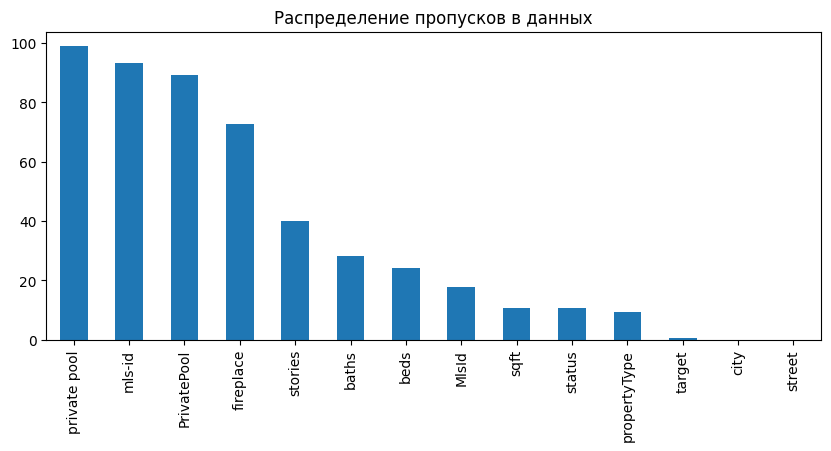

In [6]:
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

На входе мы имеем датасет с 18 признаками, в том числе с целевым. Число записей равно 377185. В данных есть пропуски, но возможно часть из них обоснована (нет камина, бассейна и т.п.)

In [7]:
# Проверим наличие полных дубликатов
number_of_duplicates = df[df.duplicated()].shape[0]
print(f'Количество дубликатов: {number_of_duplicates}')

Количество дубликатов: 50


In [8]:
# Удаляем дубликаты:
df = df.drop_duplicates()
print(f'Размер таблицы после удаления дубликатов: {df.shape}')

Размер таблицы после удаления дубликатов: (377135, 18)


In [9]:
# удалим записи, в которых есть пропуски целевой переменной
df = df[~df['target'].isnull()]

### Бассейн

In [10]:
# Посмотрим, какими значениями представлен бассейн
display(df['private pool'].unique())
display(df['PrivatePool'].unique())

array([nan, 'Yes'], dtype=object)

array([nan, 'yes', 'Yes'], dtype=object)

In [11]:
# преобразовываем
df['private_pool'] = df[['private pool', 'PrivatePool']].apply(lambda x: 0 if x[0] != x[0] and x[1] != x[1] else 1, axis=1)

# удаляем
df = df.drop(columns=['private pool', 'PrivatePool'])

# посмотрим
df['private_pool'].value_counts()

private_pool
0    330384
1     44271
Name: count, dtype: int64

### Идентификатор MLS (Multiple Listing Service, система мультилистинга)  
Признак идентификатор MLS, вряд ли может быть фактором влияющим на оценку, но возможно на цену влияет само попадание объекта недвижимости в MLS.

До того как преобразовывать MLS в категориальный признак, проверю, есть ли одинаковые идентификаторы.

In [12]:
df['mls-id'].value_counts()[:10]

mls-id
No           3
No MLS#      3
983469       2
241766       2
A10761504    2
39888954     2
608063       2
201906177    2
19-3389      2
20193733     2
Name: count, dtype: int64

In [13]:
df['MlsId'].value_counts()[:10]

MlsId
NO MLS                        24
No MLS #                      16
 A, Houston, TX 77008         13
 12A, Orlando, FL 32833       11
 B, Houston, TX 77008          9
 1, South Boston, MA 02127     9
No                             9
 2, Washington, DC 20002       8
 11A, Orlando, FL 32833        8
No mls                         8
Name: count, dtype: int64

Совпадения есть, но неожиданно выяснилось, что кроме идентификатора, там содержатся значения, явно на него не похожие.

In [14]:
# немного почистим

def clearing_mls(feature):
    if not feature != feature:
        feature_temp = ' '.join(feature.strip().split()).upper() # удалены лишние пробелы и переведен к верхнему регистру
        if feature_temp == 'NO': return np.nan
        if 'NO MLS' in feature_temp: return np.nan
        if feature_temp == 'NOMLSID': return np.nan
        return feature_temp
    return feature

df['MlsId'] = df['MlsId'].apply(clearing_mls)
df['mls-id'] = df['mls-id'].apply(clearing_mls)

In [15]:
df['mls-id'].value_counts()[:10]

mls-id
19079093      2
1498550       2
241962        2
DW19268386    2
A10761504     2
2152042       2
898065        2
1530716       2
190004138     2
233481        2
Name: count, dtype: int64

In [16]:
df[df['mls-id'] == '19079093']

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,private_pool
266665,For sale,Single Family,3540 Lucy St,Bathrooms: 1,"{'atAGlanceFacts': [{'factValue': '1950', 'fac...",NaN,Saint Louis,"[{'rating': ['3/10', '1/10', '1/10'], 'data': ...",Total interior livable area: 915 sqft,63116,2 bd,MO,1.0,19079093,NaN,"$125,000",0
331558,For sale,Single Family,3024 Mcgerry St,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '1974', 'fac...",NaN,Modesto,"[{'rating': ['4/10', '4/10', '6/10'], 'data': ...","Total interior livable area: 1,342 sqft",95355,3 bd,CA,1.0,19079093,NaN,"$325,000",1


Здесь явно разные объекты с одним идентификатором. Возможно в разных регионах базы MLS разные и поэтому возможно пересечение идентификаторов

In [17]:
df[df['mls-id'] == '1498550']

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,private_pool
113074,For sale,Condo,600 Wall St # 2008,2 ba,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Seattle,"[{'rating': ['NA'], 'data': {'Distance': ['0.2...","1,183 sqft",98109,2 bd,WA,NaN,1498550,NaN,"$1,784,950",0
285254,For sale,Condo,600 Wall St # 2208,Bathrooms: 2,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Seattle,"[{'rating': ['NA'], 'data': {'Distance': ['0.2...","Total interior livable area: 1,183 sqft",98109,2 bd,WA,NaN,1498550,NaN,"$1,784,950",0


А здесь явно одинаковые, с вариативностью заполнения. Но объекты в одном городе.

Посмотрим, что с другой версией идентификатора.

In [18]:
df['MlsId'].value_counts()[:10]

MlsId
A, HOUSTON, TX 77008         13
12A, ORLANDO, FL 32833       11
B, HOUSTON, TX 77008          9
1, SOUTH BOSTON, MA 02127     9
11A, ORLANDO, FL 32833        8
B, HOUSTON, TX 77007          8
2, WASHINGTON, DC 20002       8
2, WASHINGTON, DC 20010       7
1, WASHINGTON, DC 20002       7
2, WASHINGTON, DC 20009       6
Name: count, dtype: int64

In [19]:
df[df['MlsId'] == '2, WASHINGTON, DC 20010']

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,private_pool
17018,New construction,Condo,1711 Kenyon St NW # 2,2.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Washington,"[{'rating': ['5/10', '9/10', '9/10'], 'data': ...","1,416",20010,2,DC,2,NaN,"2, WASHINGTON, DC 20010","$1,025,000",0
65272,For sale,Condo,530 Irving St NW # 2,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Washington,"[{'rating': ['6/10', '4/10', '3/10'], 'data': ...","1,695",20010,3,DC,2.0,NaN,"2, WASHINGTON, DC 20010","$824,995",0
234845,New construction,Townhouse,3319 Sherman Ave NW # 2,3.0,"{'atAGlanceFacts': [{'factValue': '1912', 'fac...",NaN,Washington,"[{'rating': ['5/10', '6/10'], 'data': {'Distan...","3,100",20010,2,DC,2,NaN,"2, WASHINGTON, DC 20010","$784,900",0
262881,For sale,Townhouse,435 Park Rd NW # 2,3.0,"{'atAGlanceFacts': [{'factValue': '1907', 'fac...",NaN,Washington,"[{'rating': ['6/10', '4/10', '3/10'], 'data': ...","1,580",20010,2,DC,2,NaN,"2, WASHINGTON, DC 20010","$669,900",0
267643,For sale,Townhouse,3313 Sherman Ave NW # 2,3.0,"{'atAGlanceFacts': [{'factValue': '1912', 'fac...",NaN,Washington,"[{'rating': ['5/10', '6/10'], 'data': {'Distan...","1,550",20010,2,DC,2,NaN,"2, WASHINGTON, DC 20010","$775,000",0
315818,For sale,Condo,1340 Kenyon St NW # 2,2,"{'atAGlanceFacts': [{'factValue': '1909', 'fac...",NaN,Washington,"[{'rating': ['5/10', '6/10'], 'data': {'Distan...","1,200",20010,2,DC,1.0,NaN,"2, WASHINGTON, DC 20010","$799,000",0
322121,For sale,Single Family,3519 New Hampshire Ave NW # 2,3,"{'atAGlanceFacts': [{'factValue': '1913', 'fac...",NaN,Washington,"[{'rating': ['5/10', '6/10'], 'data': {'Distan...","1,700",20010,3,DC,2.0,NaN,"2, WASHINGTON, DC 20010","$775,000",0


Здесь не смотря на один идентификатор объекты разные.

Посмотрим на еще один вариант.

In [20]:
df[df['MlsId'] == '2088662']

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,private_pool
172682,Active,Single Family Home,3514 Hilldale Dr,4.5+,"{'atAGlanceFacts': [{'factValue': '2020', 'fac...",2,Nashville,"[{'rating': ['NR', '5', '3', '6', '5', '5', 'N...",5362,37215,4.0,TN,2.00,NaN,2088662,"$1,795,000",0
181057,Active,Condo/Townhome/Row Home/Co-Op,155 S Sable Blvd Apt S22,2,"{'atAGlanceFacts': [{'factValue': '1982', 'fac...",NaN,Aurora,"[{'rating': ['3', '3', '2', '6', '2', 'NR', 'N...",1036,80012,2,CO,Condominium,NaN,2088662,"$195,000",0
208039,for sale,condo,155 S Sable Blvd #S22,2 Baths,"{'atAGlanceFacts': [{'factValue': '1982', 'fac...",yes,Aurora,"[{'rating': ['3/10', '2/10', '2/10'], 'data': ...","1,036 sqft",80012,2 Beds,CO,NaN,NaN,2088662,"$195,000",0
266441,Active,NaN,155 S Sable Blvd Unit S22,NaN,"{'atAGlanceFacts': [{'factValue': '1982', 'fac...",NaN,AURORA,"[{'rating': ['2', '3', '2', '2'], 'data': {'Di...","1,036",80012,NaN,CO,NaN,NaN,2088662,"195,000",0
294083,for sale,single-family home,3514 Hilldale Dr,6 Baths,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",yes,Nashville,"[{'rating': ['4/10', 'None/10', '5/10'], 'data...","5,362 sqft",37215,4 Beds,TN,2.0,NaN,2088662,"$1,795,000",0
302551,Active,NaN,3514 Hilldale Dr,~,"{'atAGlanceFacts': [{'factValue': '2020', 'fac...",2,Nashville,"[{'rating': ['NR', '3', '5', '8', '3', '1'], '...","5,362",37215,Baths,TN,NaN,NaN,2088662,"1,795,000",0


А здесь все еще интереснее. Явно присутствуют объекты одинаковые и разные.

Вывод после исследования MLS.
- Брать MLS как уникальный идентификатор нельзя;
- В датасете присутствуют дубли объектов с вариативностью указания признаков (Например: baths: '2'; '2 Baths' и street: '155 S Sable Blvd Apt S22'; '155 S Sable Blvd #S22');
- Очень сильно подозреваю, что и в объектах с незаполненным MLS та же картина.

Соответственно, надо чистить и приводить к одному формату, а после удалять получившиеся дубли.
А пока приведем MLS в категориальный признак (заполнено/нет)

In [21]:
# дополняем один признак значениями другого
df['MlsId'] = df['MlsId'].fillna(df['mls-id'])

# удаляем лишний
df = df.drop(columns=['mls-id'])

# преобразуем в категориальный
df['MlsId'] = df['MlsId'].apply(lambda x: 0 if x != x else 1)

### Целевой признак target

In [22]:
df['target'].head()

0      $418,000
1      $310,000
2    $2,895,000
3    $2,395,000
4        $5,000
Name: target, dtype: object

Значение признака требуется преобразовать в числовой формат. Для этого удалим все нечисловые символы, кроме точки

In [23]:
# преобразовываем
non_decimal = re.compile(r'[^\d.]+')
df['target'] = df['target'].apply(lambda x: float(non_decimal.sub('', x)))
# посмотрим на результат
df['target'].head()

0     418000.0
1     310000.0
2    2895000.0
3    2395000.0
4       5000.0
Name: target, dtype: float64

Проверим статистические характеристика целевого признака

In [24]:
df['target'].describe()

count    3.746550e+05
mean     6.447596e+05
std      1.841482e+06
min      1.000000e+00
25%      1.869900e+05
50%      3.200000e+05
75%      5.820000e+05
max      1.950000e+08
Name: target, dtype: float64

Разброс довольно большой. Минимум $1, а максимум $195 миллионов. Посмотрим более наглядно.

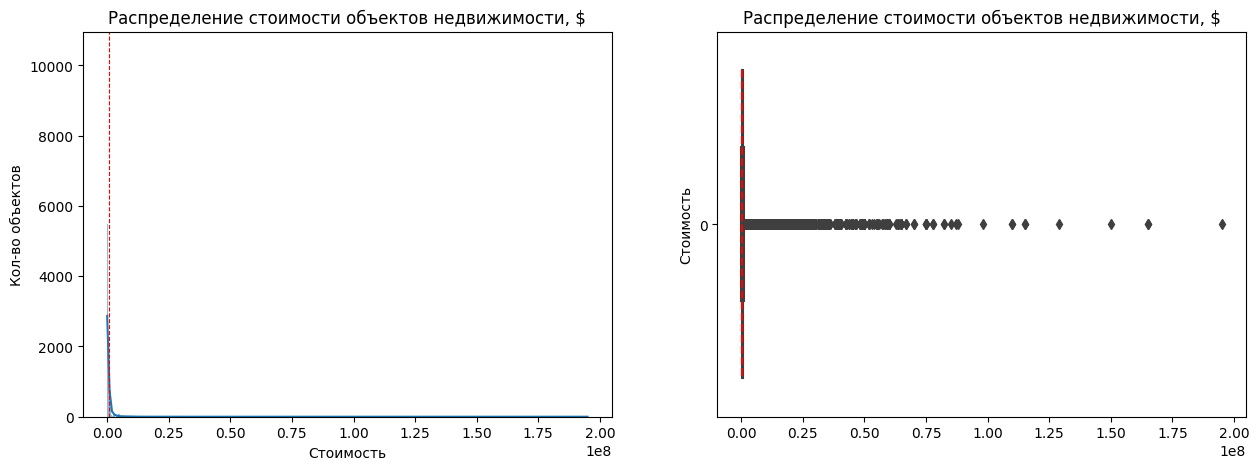

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['target'], kde=True, ax=axes[0])
axes[0].set(xlabel='Стоимость', ylabel='Кол-во объектов')
axes[0].set_title('Распределение стоимости объектов недвижимости, $')
axes[0].axvline(df['target'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(df['target'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Стоимость')
axes[1].set_title('Распределение стоимости объектов недвижимости, $')

plt.show()

Явно видно наличие выбросов. В дальнейшем проанализируем более подробно и очистим датасет от выбросов.

### Признак status

In [26]:
df['status'].value_counts()

status
for sale                   156054
Active                     105206
For sale                    43464
foreclosure                  5677
New construction             5458
                            ...  
Coming soon: Nov 8.             1
Coming soon: Oct 29.            1
Coming soon: Dec 15.            1
Pending W/Backup Wanted         1
Coming soon: Dec 23.            1
Name: count, Length: 156, dtype: int64

Сразу видно, что есть разные варианты написания одного признака: for sale, For sale и т.п.

Надо почистить и сгрупировать похожие по смыслу значения.

In [27]:
def clearing_status(feature):
    # списки синонимов
    foreclosure = ['FORECLOSURE', 'FORECLOSED', 'CONTINGENT FORECLOSURE']
    new_construction = ['NEW CONSTRUCTION', 'NEW']
    backup = ['UNDER CONTRACT W/ BCKP', 'UNDER CONTRACT TAKING BACK UP OFFERS']
    pending = ['P', 'PI', 'PF', 'PS']
    for_sale = ['PRICE CHANGE', 'BACK ON MARKET', 'LISTING EXTENDED']
    under_contract = ['C', 'DUE DILIGENCE PERIOD', 'C CONTINUE SHOW', 'CT', 'ACCEPTED OFFER', 'UC CONTINUE TO SHOW']
    
    if feature != feature:
        return 'UNDEFINED'
    else:
        # удаляем лишние пробелы и переводим в верхний регистр
        feature_temp = ' '.join(feature.strip().split()).upper()

        # замены по списку
        if feature_temp in foreclosure: return 'FORECLOSURE'
        if feature_temp in new_construction: return 'NEW'
        if feature_temp in backup: return 'BACKUP'
        if feature_temp in pending: return 'PENDING'
        if feature_temp in for_sale: return 'FOR SALE'
        if feature_temp in under_contract: return 'UNDER CONTRACT'
        
        # замены по вхождению
        if 'COMING SOON' in feature_temp: return 'COMING SOON'
        if 'PRE-FORECLOSURE' in feature_temp: return 'PRE-FORECLOSURE'
        if 'PENDING' in feature_temp: return 'PENDING'
        if 'CONTRACT' in feature_temp: return 'UNDER CONTRACT'
        if 'AUCTION' in feature_temp: return 'AUCTION'
        if 'BACKUP' in feature_temp: return 'BACKUP'
        if 'OPTION' in feature_temp: return 'OPTION'
        if 'RENT' in feature_temp: return 'RENT'
        if 'LEASE' in feature_temp: return 'RENT'
        if 'CONTINGEN' in feature_temp: return 'CONTINGENT'
        if 'ACTIV' in feature_temp: return 'FOR SALE'
        
        return feature_temp


# применяем функцию очистки
df['status'] = df['status'].apply(clearing_status)
# смотрим на результат
df['status'].value_counts()

status
FOR SALE           305925
UNDEFINED           39256
PENDING              6889
FORECLOSURE          6316
NEW                  6148
UNDER CONTRACT       3895
PRE-FORECLOSURE      3281
AUCTION              1330
CONTINGENT           1013
RENT                  421
COMING SOON           110
BACKUP                 59
OPTION                  7
CLOSED                  5
Name: count, dtype: int64

### Признак propertyType

In [28]:
df['propertyType'].value_counts()[:20]

propertyType
single-family home               91370
Single Family                    61886
Single Family Home               31725
condo                            25874
lot/land                         20506
Condo                            16494
townhouse                        11435
Land                             10933
multi-family                      7874
Condo/Townhome/Row Home/Co-Op     7701
Townhouse                         6909
Traditional                       5912
coop                              3264
Multi Family                      2771
High Rise                         1823
Ranch                             1781
Detached, One Story               1614
mobile/manufactured               1613
Single Detached, Traditional      1581
Contemporary                      1556
Name: count, dtype: int64

Почистим и сгруппируем схожие по смыслу значения.

In [29]:
def clearing_property_type(feature):
    # списки синонимов
    single_family = ['SINGLE FAMILY', 'SINGLE-FAMILY', 'SINGLE-FAMILY HOME', 'SINGLE FAMILY HOME', 'DETACHED', 'TINY HOME', 'SINGLE DETACHED', 'SINGLE DETACHED, TRADITIONAL']
    multi_family = ['MULTI-FAMILY', 'MULTI FAMILY', 'MULTI-FAMILY HOME', 'MULTI FAMILY HOME']
    mobile = ['MANUFACTURED HOME (HOUSE)', 'MFD/MOBILE HOME', 'MOBILE', 'PREFAB', 'MODULAR', 'MO2 LE', 'MO2LE', 'MOBILE/MANUFACTURE', 'MOBILE / MANUFACTURE', 'MOBILE / MANUFACTURED', 'MOBILE/MANUFACTURED']
    cabin = ['CABIN', 'CA2 N', 'CA2N']
    midcentury = ['MIDCENTURY', 'MID CENTURY', 'MID-CENTURY']
    townhouse = ['TOWNHOME', 'TOWNHOUSE']
    coop = ['CO-OP', 'COOP']
    land = ['LAND', 'LOT/LAND']
    one_story = ['ONE STORY', '1 STORY', 'DETACHED, ONE STORY']
    two_stories = ['2 STORIES', '2 STORY', 'TWO STORY', 'TWO STORIES', 'DETACHED, TWO STORY']
    modern = ['CONTEMPORARY', 'CONTEMPORARY/MODERN', 'MODERN']

    if feature != feature:
        return 'UNDEFINED'
    else:
        # удаляем лишние пробелы и переводим в верхний регистр
        feature_temp = ' '.join(feature.strip().split()).upper()
        
        # замены по списку
        if feature_temp in single_family: return 'SINGLE FAMILY'
        if feature_temp in multi_family: return 'MULTI FAMILY'
        if feature_temp in mobile: return 'MOBILE'
        if feature_temp in cabin: return 'CABIN'
        if feature_temp in midcentury: return 'MIDCENTURY'
        if feature_temp in townhouse: return 'TOWNHOUSE'
        if feature_temp in coop: return 'COOP'
        if feature_temp in land: return 'LAND'
        if feature_temp in one_story: return '1 STORY'
        if feature_temp in two_stories: return '2 STORIES'
        if feature_temp == '': return 'UNDEFINED'
        if feature_temp in modern: return 'MODERN'
 
        # замены по вхождению
        if '1 STORY' in feature_temp: return '1 STORY'
        if '2 STORY' in feature_temp: return '2 STORIES'
        if '2 STORIES' in feature_temp: return '2 STORIES'
        if 'OTHER' in feature_temp: return 'OTHER'
        if 'RANCH' in feature_temp: return 'RANCH'
        if 'CONDO/TOWNHOME' in feature_temp: return 'CONDO/TOWNHOME'
        if 'COOP' in feature_temp: return 'COOP'
                
        return feature_temp

df['propertyType'] = df['propertyType'].apply(clearing_property_type)


Выведем топ 50 значений и попробуем решить какая нужна еще обработка.

In [30]:
df['propertyType'].value_counts()[:50]

propertyType
SINGLE FAMILY                                 187394
CONDO                                          42368
UNDEFINED                                      34678
LAND                                           31439
TOWNHOUSE                                      18344
MULTI FAMILY                                   12167
CONDO/TOWNHOME                                  8488
TRADITIONAL                                     5912
1 STORY                                         4125
COOP                                            3834
MOBILE                                          3460
RANCH                                           3073
2 STORIES                                       2873
MODERN                                          2580
HIGH RISE                                       1823
COLONIAL                                        1204
OTHER                                            853
APARTMENT                                        797
TRANSITIONAL                     

На первый взгляд достаточно. Остальные категории можно объеденить с уже имеющейся в датасете группой OTHER.

In [31]:
# посмотрим какой % от общего числа составляет топ 20 принзнака propertyType
(df['propertyType'].value_counts(normalize=True)[:20] * 100).sum()

97.82386462211902

Учитывая, что топ 20 признака покрывает 98% наблюдений ограничусь эти числом.

In [32]:
list_top_property = df['propertyType'].value_counts()[:20].index
df['property_type'] = df['propertyType'].apply(lambda x: x if x in list_top_property else 'OTHER')
df['property_type'].value_counts()

property_type
SINGLE FAMILY     187394
CONDO              42368
UNDEFINED          34678
LAND               31439
TOWNHOUSE          18344
MULTI FAMILY       12167
OTHER               9006
CONDO/TOWNHOME      8488
TRADITIONAL         5912
1 STORY             4125
COOP                3834
MOBILE              3460
RANCH               3073
2 STORIES           2873
MODERN              2580
HIGH RISE           1823
COLONIAL            1204
APARTMENT            797
TRANSITIONAL         560
FLORIDA              530
Name: count, dtype: int64

Первоначальный признак propertyType пока не удаляю, возможно он еще пригодится.

### Признак state

In [33]:
# сразу переведем в верхний регистр и потом посмотрим
df['state'] = df['state'].str.upper()
display(df['state'].unique())
print('Число уникальных значений:', df['state'].nunique())

array(['NC', 'WA', 'CA', 'TX', 'FL', 'PA', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'AZ', 'GA', 'IL', 'NJ', 'MA', 'OH', 'IN', 'UT', 'MI', 'VT',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', 'BA', 'AL', 'OT', 'OS'], dtype=object)

Число уникальных значений: 38


Выглядит очень не плохо. 38 уникальных значений, пропусков нет, заполнение страндартное.

### Признак city

In [34]:
print('Число уникальных значений:', df['city'].nunique())
df['city'].value_counts()[:20]

Число уникальных значений: 2019


city
Houston            24406
San Antonio        15501
Miami              15411
Jacksonville        9892
Dallas              8770
Brooklyn            7244
New York            6903
Chicago             6893
Charlotte           6525
Las Vegas           5975
Fort Worth          5478
Orlando             5170
Austin              5133
Fort Lauderdale     5082
Cleveland           5006
Nashville           4987
Philadelphia        4768
Tampa               4706
Washington          4584
Los Angeles         4164
Name: count, dtype: int64

2019 уникальных значений. Попробуем привести к одному виду и немного почистить.

Для начала посмотрим на строки с пропущенным значением.

In [35]:
df['city'].isnull().sum()

34

Всего 34 строки. Выведем их.

In [36]:
df[df['city'].isnull()]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,private_pool,property_type
7830,FOR SALE,SINGLE FAMILY,13155 W Highway 316,2,"{'atAGlanceFacts': [{'factValue': '2000', 'fac...",NaN,NaN,"[{'rating': ['1', '4', '3', '3', '6', '6'], 'd...",1016,32686,1,FL,2,1,1495000.0,0,SINGLE FAMILY
21529,FOR SALE,LAND,SE 117th Ter,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,32668,NaN,FL,NaN,1,49900.0,0,LAND
26467,FOR SALE,LAND,Blk 4 N America Lareedo Rd Lot 8,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,78045,NaN,TX,NaN,1,417718.0,0,LAND
60994,FOR SALE,LAND,Ocala,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34474,NaN,FL,NaN,1,31334.0,0,LAND
81514,FOR SALE,LAND,Unditermined Unditermined,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34432,NaN,FL,NaN,1,28000.0,0,LAND
122345,FOR SALE,LAND,Sw149 Ter,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34481,NaN,FL,NaN,1,18000.0,0,LAND
123490,FOR SALE,LAND,26484 Deer Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,NaN,"[{'rating': ['6', '5', '7', '7', '2', '10', 'N...",0,33955,NaN,FL,NaN,1,4000.0,0,LAND
130563,FOR SALE,SINGLE FAMILY,20003 Mar Rojo Y Mar Egeo,Bathrooms: 6,"{'atAGlanceFacts': [{'factValue': '2000', 'fac...",NaN,NaN,"[{'rating': ['5/10', 'NA', '4/10'], 'data': {'...","Total interior livable area: 5,905 sqft",20003,5 bd,MA,NaN,1,1650000.0,1,SINGLE FAMILY
131275,FOR SALE,LAND,19212 Roosevelt,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,NaN,"[{'rating': ['5', '4', '6', 'NR', '5', 'NR', '...",0,33954,NaN,FL,NaN,1,4200.0,0,LAND
151965,FOR SALE,LAND,Ocala,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,NaN,"[{'rating': [], 'data': {'Distance': [], 'Grad...",0,34474,NaN,FL,NaN,1,31334.0,0,LAND


Город очень важный признак для определения стоимости недвижимости. При этом мы видим, что улица в этих записях в основном присутствует. Соответственно можно предположить ошибки заполнения признака. Учитывая, что записей не много, удалим их.

In [37]:
df = df[~df['city'].isnull()]

In [38]:
# удаляем лишние пробелы и переводим в верхний регистр
df['city'] = df['city'].apply(lambda x: ' '.join(x.strip().split()).upper())

# удаляем строки с пустым значением
df = df[df['city'] != '']

Попробуем проверить правильность написания города, сверив его с другим источником. Для этого воспользуемся датасетом [United States Cities](https://www.kaggle.com/datasets/outwrest/simple-cities-us-dataset).

In [39]:
cities = pd.read_csv('data/uscities.csv.zip')
cities.head()

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id
0,New York,New York,NY,New York,36081,Queens,40.6943,-73.9249,18680025,10768.0,shape,False,True,America/New_York,1,11229 11228 11226 11225 11224 11222 11221 1122...,1840034016
1,Los Angeles,Los Angeles,CA,California,6037,Los Angeles,34.1141,-118.4068,12531334,3267.0,shape,False,True,America/Los_Angeles,1,91367 90291 90293 90292 91316 91311 90035 9003...,1840020491
2,Chicago,Chicago,IL,Illinois,17031,Cook,41.8375,-87.6866,8586888,4576.0,shape,False,True,America/Chicago,1,60018 60649 60641 60640 60643 60642 60645 6064...,1840000494
3,Miami,Miami,FL,Florida,12086,Miami-Dade,25.7840,-80.2101,6076316,4945.0,shape,False,True,America/New_York,1,33128 33129 33125 33126 33127 33149 33144 3314...,1840015149
4,Dallas,Dallas,TX,Texas,48113,Dallas,32.7935,-96.7667,5910669,1522.0,shape,False,True,America/Chicago,1,75098 75287 75230 75231 75236 75237 75235 7525...,1840019440


In [40]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30409 entries, 0 to 30408
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          30409 non-null  object 
 1   city_ascii    30409 non-null  object 
 2   state_id      30409 non-null  object 
 3   state_name    30409 non-null  object 
 4   county_fips   30409 non-null  int64  
 5   county_name   30409 non-null  object 
 6   lat           30409 non-null  float64
 7   lng           30409 non-null  float64
 8   population    30409 non-null  int64  
 9   density       30409 non-null  float64
 10  source        30409 non-null  object 
 11  military      30409 non-null  bool   
 12  incorporated  30409 non-null  bool   
 13  timezone      30409 non-null  object 
 14  ranking       30409 non-null  int64  
 15  zips          30407 non-null  object 
 16  id            30409 non-null  int64  
dtypes: bool(2), float64(3), int64(4), object(8)
memory usage: 3.5+ MB


In [41]:
# Для начала проверим штаты
# преобразуем в множество
set_state = set(cities['state_id'])
# покажем те, что не найдены.
missing_states = df[~df['state'].isin(set_state)]['state'].unique()
missing_states

array(['OT', 'OS'], dtype=object)

Некоторые штаты присутствующие в датасете, не обнаружены в другом источнике. Поиски в интернете тоже не привели к успеху. Проверим, что за строки в датасете с этими штатами.

In [42]:
df[df['state'].isin(missing_states)]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,private_pool,property_type
193466,FOR SALE,UNDEFINED,55 E 1476 Land W,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,OTHER,"[{'rating': [], 'data': {'Distance': [], 'Grad...",NaN,11210,NaN,OT,NaN,1,50000.0,0,UNDEFINED
308229,FOR SALE,UNDEFINED,435 pescador,NaN,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",NaN,FOREIGN COUNTRY,"[{'rating': [], 'data': {'Distance': [], 'Grad...","1,100",00000,NaN,OS,NaN,1,125000.0,0,UNDEFINED


Удалим.

In [43]:
df = df[~df['state'].isin(missing_states)]

In [44]:
# переведем city_ascii в верхний регистр
cities['city_ascii_upper'] = cities['city_ascii'].str.upper()
# преобразуем список городов в множество
set_cities = set(cities['city_ascii_upper'])
# посмотрим, что не найдено
df[~df['city'].isin(set_cities)]['city'].unique()

array(['PT SAINT LUCIE', 'ROTONDA WEST', 'SYLMAR', 'BEECHHURST',
       'SAINT JOHNS', 'PORT SAINT LUCIE', 'KEW GARDENS',
       'NORTH HOLLYWOOD', 'ST PETERSBURG', 'SAINT PETE BEACH',
       'SAINT PETERSBURG', 'LITTLE NECK', 'WATERSOUND', 'WINSTON SALEM',
       'HIXSON', 'LONG ISLAND CITY', 'WADDELL', 'SOUTH OZONE PARK',
       'LA JOLLA', 'LAKE BALBOA', 'TUJUNGA', 'BABCOCK RANCH', 'REUNION',
       'SODDY DAISY', 'ST JOHNS', 'EAST BOSTON', 'ARLETA', 'JOELTON',
       'ENOSBURG', 'PLACIDA', 'ST PETE BEACH', 'SAINT LOUIS', 'VAN NUYS',
       'TARZANA', 'HIGH PT', 'HUFFMAN', 'EAST PT', 'BOCA GRANDE',
       'FAIRFIELD TWP', 'OLMSTED TOWNSHIP', 'NORRIDGEWOCK', 'OSTERVILLE',
       'BARNSTABLE', 'CHIMNEY ROCK', 'CHEEKTOWAGA', 'RICHMOND HTS',
       'QUEENS VILLAGE', 'UNINCORPORATED', 'CORRYTON', 'EAST ELMHURST',
       'GARFIELD HTS', 'BUSTI', 'HARBOR CITY', 'RESEDA', 'OLD HICKORY',
       'OPA LOCKA', 'DOWNTOWN PGH', 'SHERMAN OAKS', 'PACOIMA',
       'SHELBURNE', 'COMMERCECITY', 'PINEY

Бросается в глаза разное написание городов: 'ST PETERSBURG' и 'SAINT PETERSBURG'.  
А так же наличие таких городов как:
- OTHER CITY NOT IN THE STATE OF FLORIDA
- OTHER CITY VALUE OUT OF AREA
- OTHER

In [45]:
df[df['city'].str.contains('PETERSBURG')][['city', 'state']].value_counts()

city              state
SAINT PETERSBURG  FL       2511
ST PETERSBURG     FL       1145
ST. PETERSBURG    FL         12
PETERSBURG        FL         11
Name: count, dtype: int64

На примере города ST. PETERSBURG мы видим 4 варианта написания города. Надо приводить в порядок.

Идея следующая. С помощью метода get_close_matches из модуля difflib будем искать похожие по написанию города внутри штата.

In [46]:
# объявим словарь в котором будем хранить уже найденные значения
found_city = {}
def city_search(state_city):
    #global found_city
    if (state_city[0], state_city[1]) in found_city:
        # уже есть в словаре
        return found_city[(state_city[0], state_city[1])]
    else:
        # ищем список городов для штата
        ls_cities = list(cities[cities['state_id'] == state_city[0]]['city_ascii_upper'])
        # подбираем похожий город
        res = difflib.get_close_matches(state_city[1], ls_cities)
        if res == []:
            # не нашли ничего похожего
            return 'NOT FOUND'
        else:
            # нашли похожий город
            # пишем в словарь
            found_city[(state_city[0], state_city[1])] = res[0]
            return res[0]

df['city_2'] = df[['state', 'city']].apply(city_search, axis=1)

Посмотрим еще раз что получилось

In [47]:
# преобразуем список городов в множество
set_cities = set(cities['city_ascii_upper'])
# посмотрим, что не найдено
df[~df['city_2'].isin(set_cities)]['city_2'].unique()

array(['NOT FOUND'], dtype=object)

Посмотрим, какие города не удалось найти.

In [48]:
df[df['city_2'] == 'NOT FOUND']['city'].value_counts()[:20]

city
FLUSHING                                1294
SAINT JOHNS                              576
ANTIOCH                                  402
OLD HICKORY                              210
HERMITAGE                                208
CORDOVA                                  156
WADDELL                                  110
VAN NUYS                                 105
TUJUNGA                                   87
ESSEX                                     62
FAIRFAX                                   49
WINNETKA                                  49
UNINCORPORATED                            38
PEMBROKE                                  34
NORRIDGEWOCK                              34
SAINT ALBANS                              31
SHELBURNE                                 31
OTHER CITY - IN THE STATE OF FLORIDA      28
RICHFORD                                  28
ROME                                      28
Name: count, dtype: int64

Поиски в интернете показали что FLUSHING это один из старейших районов Куинса, расположенный в северо-центральной части города Нью-Йорк.  
А SAINT JOHNS округ в северо-восточной части американского штата Флорида.  
Т.е. это некое указание на территорию объекта. Можно оставить так.

In [49]:
# Проведем небольшие замены значений
df['city_2'] = df[['city', 'city_2']].apply(lambda x: 'OTHER' if 'OTHER' in x[0] else x[1], axis=1)

df['city_2'] = df[['city', 'city_2']].apply(lambda x: x[0] if x[1] == 'NOT FOUND' else x[1], axis=1)

In [50]:
# и посмотрим на топ 50
df['city_2'].value_counts()[:50]

city_2
HOUSTON            24406
SAN ANTONIO        15501
MIAMI              15415
JACKSONVILLE        9909
DALLAS              8772
BROOKLYN            7246
ORLANDO             6975
NEW YORK            6929
CHICAGO             6893
CHARLOTTE           6479
TAMPA               6421
LAS VEGAS           5979
FORT WORTH          5507
AUSTIN              5133
FORT LAUDERDALE     5091
CLEVELAND           5006
NASHVILLE           4989
PHILADELPHIA        4768
WASHINGTON          4587
LOS ANGELES         4169
SEATTLE             4058
KISSIMMEE           3957
ATLANTA             3951
ST. PETERSBURG      3681
OCALA               3322
PALM COAST          3245
PORT CHARLOTTE      3150
DETROIT             3113
INDIANAPOLIS        2679
MIAMI BEACH         2637
DENVER              2622
LEHIGH ACRES        2495
MEMPHIS             2485
RALEIGH             2460
PUNTA GORDA         2414
PORTLAND            2121
CHATTANOOGA         2032
EL PASO             2019
RENO                1845
DURHAM            

Выглядит неплохо.

### Признак baths

In [51]:
# посмортим на признак
df['baths'].value_counts()

baths
2 Baths       52072
3 Baths       35393
2             20427
2.0           16354
4 Baths       14723
              ...  
0.5 Baths         1
4.75 Baths        1
5.25 Baths        1
41.0              1
44.0              1
Name: count, Length: 226, dtype: int64

Обращает на себя внимание дробное количество ванных комнат и два объекта с количеством ванных комнат 41 и 44.

Посмотрим на них.

In [52]:
df[(df['baths'] == '41.0') | (df['baths'] == '44.0')]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,private_pool,property_type,city_2
147176,UNDEFINED,CONDO,4610 Alton Rd # 4610,41.0,"{'atAGlanceFacts': [{'factValue': 'No Data', '...",NaN,MIAMI BEACH,"[{'rating': ['10/10', '4/10', '5/10'], 'data':...","5,101 sqft",33140,4,FL,NaN,1,2590000.0,0,CONDO,MIAMI BEACH
360980,FOR SALE,MULTI FAMILY,40 Parker Hill Ave # 44,44.0,"{'atAGlanceFacts': [{'factValue': '1910', 'fac...",NaN,BOSTON,"[{'rating': ['2/10', '9/10'], 'data': {'Distan...","21,210",02120,78,MA,NaN,1,20000000.0,0,MULTI FAMILY,BOSTON


По объекту с типом MULTI FAMILY большое количество ванных комнат выглядит обоснованным, т.к. присутствует большая площадь объекта и наличие спален в количестве 78 штук оправдывает 44 ванных. А вот по другому объекту нет. Его площадь меньше и спален всего 4. После очистки признака надо будет поработать над очисткой от выбросов и ошибочных значений.

Что касается дробного числа ванных комнат, то поиски в интернете показали, что такое обозначение принято в США. В 0,5 ванной может быть указан туалет с раковиной.  
[Источник информации](http://begin-english.ru/article/chto-nuzhno-znat-ob-amerikanskom-dome/)

In [53]:
df['baths'].unique()

array(['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3',
       'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5',
       '1,000', '7 Baths', '2.0', '3.0', 'Bathrooms: 1', '4.0',
       '2.1 Baths', '2.5 Baths', '1', 'Bathrooms: 3', '4.5', '6 Baths',
       'Bathrooms: 4', '3 ba', '5', '2,500', '5.5 Baths', '1.0',
       '5 Baths', '1.5', '4', '~', '2.5', '4,000', '3.5 Baths', '2,000',
       '3,000', '8.0', '1 ba', '0', '5.0', '1,500', '7.0', '1,250',
       '9 Baths', '2,250', '6.0', '12 Baths', '5.5', '3,500', '1.5 Baths',
       '2,750', 'Bathrooms: 6', '4.5 Baths', '750', '5.5+', '6',
       '10 Baths', '6 ba', 'Bathrooms: 19', '10.0', '4 ba', '12 ba',
       '2.5+', '8', '7.5+', 'Bathrooms: 10', '0 / 0', 'Sq. Ft. ', '5 ba',
       '4.5+', '18 Baths', '-- baths', 'Bathrooms: 7', '7', '18', '3.5+',
       '1.5+', '11 Baths', '5,000', '1.75 Baths', '9', '12.0', '6.5',
       'Bathrooms: 8', '10', '19 Baths', 'Bathrooms: 9', '16 Baths',
       '13 Baths', 'Bathrooms: 13

In [54]:
# проведем некоторые замены и преобразования текста.
def clearing_baths(feature):
    # списки синонимов
    one_bath = ['1 / 1-0 / 1-0 / 1-0']
    two_baths = ['1-2 BATHS']
    three_baths = ['1-0 / 1-0 / 1', '3-1 / 2-2']
    four_baths = ['1 / 1 / 1 / 1', '2-1 / 2-1 / 1-1 / 1-1']
    nan_bath = ['116 / 116 / 116']

    if feature != feature:
        return feature
    else:
        # удаляем лишние пробелы, переводим в верхний регистр, меняем запятые на точки
        feature_temp = ' '.join(feature.strip().split()).upper().replace(',', '.')
        
        # замены по списку
        if feature_temp in one_bath: return '1'
        if feature_temp in two_baths: return '2'
        if feature_temp in three_baths: return '3'
        if feature_temp in four_baths: return '4'
        if feature_temp in nan_bath: return np.nan
 
        # замены по вхождению
        # if '' in feature_temp: return ''
                
        return feature_temp

# переведем признак во float обрабатывая ошибки
def feature_to_float(feature):
    if feature != feature:
        return feature
    else:
        try:
            float_num=float(feature)
            return float_num
        except ValueError:
            return np.nan    
    
# чистим
df['baths'] = df['baths'].apply(clearing_baths)

# преобразовываем
df['baths'] = df['baths'].replace(to_replace=r'[^\d.]+', value='', regex=True)
df['baths'] = df['baths'].apply(feature_to_float)


In [55]:
df['baths'].value_counts()

baths
2.0     102741
3.0      66422
4.0      26240
1.0      17521
2.5      13747
         ...  
76.0         1
14.5         1
5.2          1
35.0         1
68.0         1
Name: count, Length: 80, dtype: int64

Отлично признак преобразовали, осталось исключить заведомо ложные данные и заполнить пропуски.

Но делать это я буду после того, как очищу признаки beds и sqft.

### Признак beds

In [56]:
df['beds'].value_counts()

beds
3 Beds        53072
4 Beds        35219
3             31190
2 Beds        26189
4             19915
              ...  
5,510 sqft        1
3.8 acres         1
7,104 sqft        1
9,443 sqft        1
8,479 sqft        1
Name: count, Length: 1147, dtype: int64

О как! В признаке количество спален, есть площадь объекта. Посмотрим, возможно это дублирование данных в признаках?

In [57]:
# переведем в верхний регистр
df['beds'] = df['beds'].str.upper()

In [58]:
mask_1 = df['beds'].str.contains('SQFT')
mask_2 = df['beds'].str.contains('ACRES')
mask_3 = df['sqft'].isnull()
print('Заполненный sqft:')
display(df[(mask_1 | mask_2) & ~mask_3][['beds', 'sqft', 'property_type', 'propertyType']].head())
print('Не заполненный sqft:')
display(df[(mask_1 | mask_2) & mask_3][['beds', 'sqft', 'property_type', 'propertyType']].head())

Заполненный sqft:


,beds,sqft,property_type,propertyType
3434,"6,351 SQFT","1,076 sqft",OTHER,SINGLEFAMILYRESIDENCE
6694,"5,662 SQFT",-- sqft,OTHER,SINGLEFAMILYRESIDENCE
13622,0.71 ACRES,-- sqft,OTHER,SINGLEFAMILYRESIDENCE
17990,1.8 ACRES,-- sqft,OTHER,SINGLEFAMILYRESIDENCE
22755,0.32 ACRES,-- sqft,OTHER,SINGLEFAMILYRESIDENCE


Не заполненный sqft:


,beds,sqft,property_type,propertyType
279,0.25 ACRES,NaN,UNDEFINED,UNDEFINED
491,0.44 ACRES,NaN,UNDEFINED,UNDEFINED
548,1.43 ACRES,NaN,UNDEFINED,UNDEFINED
734,0.32 ACRES,NaN,UNDEFINED,UNDEFINED
971,"8,637 SQFT",NaN,UNDEFINED,UNDEFINED


Нет, это не дублирование данных. Даже там где заполнен признак sqft, чаще всего он заполнен прочерком "-- sqft". Перенесем данные, чтобы не потерять значения.

In [59]:
index_list = df[(mask_1 | mask_2)].index
df.loc[index_list, 'sqft'] = df.loc[index_list, 'beds']
df.loc[index_list, 'beds'] = np.nan


In [60]:
df['beds'].unique()

array(['4', '3 BEDS', '5 BEDS', nan, '2 BEDS', '3', '4 BEDS', '3 BD',
       'BATHS', '4 BD', '5 BD', '8 BEDS', '2', '2 BD', '2.0', '5', '1',
       '3.0', '6 BEDS', 'BATH', '12 BEDS', '6', '14', '-- BD', '7', '5.0',
       '4.0', ' ', '7 BEDS', '1 BD', '9 BEDS', '0', '6 BD', '7.0',
       '16 BEDS', '1.0', '16 BD', '8', '6.0', '13 BD', '9', '10',
       '18 BEDS', '10 BEDS', '20 BEDS', '0.0', '10 BD', '32', '13 BEDS',
       '7 BD', '11', '26 BEDS', '64 BEDS', '9 BD', '12 BD', '8 BD', '144',
       '22 BEDS', '12', '11 BEDS', '24 BD', '14 BEDS', '15', '10.0',
       '8.0', '1 BATH, 2 BEDROOMS, LIVING ROOM, RANGE/OVEN, REFRIGERATOR',
       '28 BEDS', '32 BEDS', '16', '15 BEDS', '1 ACRE', '36 BEDS',
       '11 BD', '19 BD', '48', '28', '25 BEDS', '18', '24 BEDS',
       '17 BEDS', '27', '20', '20 BD', '14 BD', '27 BD', '15 BD', '13',
       '40', '47 BEDS', '26 BD', '23 BEDS', '44 BEDS', '12.0', '30.0',
       '22', '33', '9.0', '14.0', '13.0', '31 BEDS', '23 BD', '16.0',
       '34 BE

In [61]:
# почистим
def clearing_beds(feature):
    if not feature != feature:
        # замены по вхождению
        if '3 OR MORE BEDROOMS' in feature: return '3'
        if '2 BEDROOMS' in feature: return '2'
        if "BASED ON REDFIN'S" in feature: return np.nan
                
    return feature

# переведем признак в int обрабатывая ошибки
def feature_to_int(feature):
    if feature != feature:
        return feature
    else:
        try:
            int_num=int(feature)
            return int_num
        except ValueError:
            return np.nan    

# чистим
df['beds'] = df['beds'].apply(clearing_beds)

# преобразовываем
df['beds'] = df['beds'].replace(to_replace=r'[^\d.]+', value='', regex=True)
df['beds'] = df['beds'].apply(feature_to_int)

Посмотрим сколько пропусков содержит признак и примем решение об их заполнении.

In [62]:
df['beds'].isnull().sum()

129221

Пропусков много. Посмотрим на тип объекта.

In [63]:
df[df['beds'].isnull()]['propertyType'].value_counts()

propertyType
UNDEFINED                                                      34053
LAND                                                           28957
SINGLE FAMILY                                                  19148
CONDO                                                           6960
TRADITIONAL                                                     5911
                                                               ...  
BUNGALOW, TRANSITIONAL                                             1
SINGLE DETACHED, VACATION HOME                                     1
BUNGALOW, CONTEMPORARY, CRAFTSMAN, CUSTOM                          1
2 UNIT CONDO                                                       1
BILEVEL, CONVERTED DWELLING, LOFT WITH BEDROOMS, CONDO/UNIT        1
Name: count, Length: 812, dtype: int64

Есть предположение, что риелторы не всегда заполняют количество спален. Заполним медианой.

In [64]:
median_beds = df['beds'].median()
df['beds'] = df['beds'].fillna(median_beds)

Посмотрим, что получилось.

In [65]:
df['beds'].describe()

count    374599.000000
mean          3.240027
std           1.388779
min           0.000000
25%           3.000000
50%           3.000000
75%           4.000000
max         144.000000
Name: beds, dtype: float64

Странное значение в количестве 144 спальни.

In [66]:
df[df['beds'] == 144]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,private_pool,property_type,city_2
7324,FOR SALE,MULTI FAMILY,2202 Bristol Rd,2.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,LAREDO,"[{'rating': ['7', '8', '4', '8', '9', '6', 'NR...",62376,78045,144.0,TX,NaN,1,1590000.0,0,MULTI FAMILY,LAREDO


Возможно, учитывая прощадь объекта.

Посмотрим, на объекты выше 75 процентиля.

In [67]:
df[df['beds'] > 4]['beds'].value_counts()

beds
5.0      20236
6.0       6225
7.0       1751
8.0       1164
9.0        474
10.0       261
12.0       185
11.0       130
16.0        66
13.0        47
64.0        44
14.0        42
15.0        31
18.0        31
24.0        30
20.0        19
17.0        12
32.0         9
28.0         9
26.0         8
22.0         8
19.0         6
34.0         6
21.0         5
23.0         5
27.0         4
40.0         4
30.0         3
44.0         3
25.0         3
36.0         3
47.0         2
48.0         2
78.0         2
33.0         2
42.0         2
29.0         2
39.0         1
35.0         1
76.0         1
46.0         1
52.0         1
144.0        1
75.0         1
51.0         1
53.0         1
99.0         1
31.0         1
88.0         1
Name: count, dtype: int64

Видно, что чем больше спален тем меньшее количество объектов недвижимости. Попробуем соотнести с признаком sqft после его очистки.

### Признак sqft

Помним, что у нас есть площадь в разных единицах футы и акры.

In [68]:
df['sqft'].value_counts()

sqft
0              11824
1,200 sqft       829
1,000 sqft       648
1,100 sqft       570
1,800 sqft       562
               ...  
7,162 sqft         1
8,210 sqft         1
12,002 sqft        1
5,732              1
8,479 SQFT         1
Name: count, Length: 26363, dtype: int64

In [69]:
# почистим
def clearing_sqft(feature):
    non_decimal = re.compile(r'[^\d.]+')
    
    if not feature != feature:
        # переведем значение в верхний регистр
        feature = feature.upper()
        if 'ACR' in feature:
            # 1 акр равно 43 559.995 футов квадратных
            ratio = 43559.995
        else:
            ratio = 1
        try:
            feature = float(non_decimal.sub('', feature)) * ratio
            return feature
        except ValueError:
            return np.nan         
        
    return feature

df['sqft'] = df['sqft'].apply(clearing_sqft)

# пропуски заполним медианой
median_sqft = df['sqft'].median()
df['sqft'] = df['sqft'].fillna(median_sqft)


Вернемся к спальням. Соотнесем количество спален к прощади объекта.

In [70]:
df_group = df.groupby(by=['beds']).agg({'beds':'count','sqft':'sum'})
tmp = (df_group['sqft'] / (df_group.index * df_group['beds'])).sort_index(ascending=False)
tmp

beds
144.0     433.166667
99.0      308.080808
88.0      327.545455
78.0      271.923077
76.0      492.026316
75.0      526.853333
64.0       28.234375
53.0      557.283019
52.0      559.538462
51.0      936.470588
48.0      347.395833
47.0      333.776596
46.0       81.739130
44.0      383.810606
42.0      269.166667
40.0      389.812500
39.0      410.256410
36.0      345.018519
35.0      456.228571
34.0      282.759804
33.0      478.333333
32.0      460.440972
31.0      477.451613
30.0      333.866667
29.0      421.293103
28.0      489.896825
27.0      548.796296
26.0      416.663462
25.0      645.306667
24.0      405.488889
23.0      259.721739
22.0      494.823864
21.0      663.790476
20.0      621.973684
19.0      592.359649
18.0      419.589606
17.0      675.303922
16.0      437.500000
15.0      433.954839
14.0      490.595238
13.0      533.839607
12.0      825.869369
11.0      513.860839
10.0      491.760153
9.0       556.936240
8.0       597.957259
7.0       779.963776
6.0     

Видим две позиции выбивающихся из общей картины.
Посмотрим, есть ли еще?

In [71]:
tmp[tmp < 100]

beds
64.0    28.234375
46.0    81.739130
dtype: float64

Посмотрим, что это за объекты.

In [72]:
df[(df['beds'] == 64) | (df['beds'] == 46)].head()

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,private_pool,property_type,city_2
6317,FOR SALE,LAND,5906 Elk Hound Trl,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,GREENSBORO,"[{'rating': ['5/10', '6/10', '5/10'], 'data': ...",1807.0,27409,64.0,NC,NaN,1,250000.0,0,LAND,GREENSBORO
28785,FOR SALE,LAND,4218 Farlow Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,GREENSBORO,"[{'rating': ['3/10', '7/10', '6/10'], 'data': ...",1807.0,27406,64.0,NC,NaN,1,39900.0,0,LAND,GREENSBORO
34168,FOR SALE,LAND,1505 Hardie St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,GREENSBORO,"[{'rating': ['4/10', '5/10', '4/10'], 'data': ...",1807.0,27403,64.0,NC,NaN,1,23500.0,0,LAND,GREENSBORO
34379,FOR SALE,LAND,1604 Sharpe Rd,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,GREENSBORO,"[{'rating': ['3/10', '7/10', '6/10'], 'data': ...",1807.0,27406,64.0,NC,NaN,1,25000.0,0,LAND,GREENSBORO
57736,FOR SALE,LAND,900 Pine Circle Dr,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,HIGH PT,"[{'rating': ['1/10', '3/10', '3/10'], 'data': ...",1807.0,27265,64.0,NC,NaN,1,62600.0,0,LAND,HIGH POINT


Что за типы объектов?

In [73]:
df[(df['beds'] == 64) | (df['beds'] == 46)]['property_type'].value_counts()

property_type
LAND            44
MULTI FAMILY     1
Name: count, dtype: int64

Всего 45 объектов один из которых MULTI FAMILY, а остальные LAND. Наличие спален в которых в принципе сомнительно...  
Пока оставим так как есть.

Вернемся к ванным комнатам. Соотнесем количество ванных комнат с количеством спален + бассейн. Для аномальных значений исправим этот показатель.  
Сначала посмотрим на статистику.

In [74]:
df['baths'].describe()

count    267813.000000
mean          3.383163
std          22.272078
min           0.000000
25%           2.000000
50%           2.500000
75%           3.000000
max         750.000000
Name: baths, dtype: float64

750 ванных комнат!? Это слишком. При этом 75 персентиль не вызывает подозрений.

In [75]:
# отберем значания где число ванных превышает число спален + бассейн на 2
df[(df['baths'] - df['beds'] - df['private_pool']) > 2][['beds', 'private_pool', 'baths']]

,beds,private_pool,baths
3,5.0,0,8.0
345,5.0,1,9.0
1109,3.0,0,750.0
1116,3.0,0,5.5
1349,16.0,0,19.0
...,...,...,...
376749,5.0,0,8.0
376772,3.0,0,750.0
376896,6.0,0,9.0
376901,5.0,0,7.5


Таких значений очень много, 1756 объектов. Сомнительно, что все эти значения ошибочны...  
Возможно есть объекты где несколько санузлов для гостей!?

Поправим только те значения где превышение более, чем в два раза.

In [76]:
# заполним пропущенные значения
mask_1 = df['baths'].isnull()
index_list = df[mask_1].index
df.loc[index_list, 'baths'] = df.loc[index_list, 'beds'] + df.loc[index_list, 'private_pool']

In [77]:
# исправим значения со значительным превышением
mask_1 = (df['baths'] // (df['beds'] + df['private_pool'])) > 2
mask_2 = df['baths'] > 2
index_list = df[mask_1 & mask_2].index
df.loc[index_list, 'baths'] = df.loc[index_list, 'beds'] + df.loc[index_list, 'private_pool']

### Признак zipcode

In [78]:
df['zipcode'].value_counts()[:20]

zipcode
32137    2139
33131    1561
34747    1484
78245    1383
34759    1332
33132    1327
33137    1306
78253    1279
78254    1228
33130    1168
34746    1149
32164    1106
33160    1103
33133    1063
33308    1023
33178    1003
33141     982
77845     962
33140     954
33304     950
Name: count, dtype: int64

Выглядит нормально, пропусков в признаке нет. Оставлю так.

### Признак fireplace

In [79]:
df['fireplace'].value_counts()

fireplace
yes                                                                     50015
Yes                                                                     20619
1                                                                       14533
2                                                                        2432
Not Applicable                                                           1990
                                                                        ...  
Gas, Wood Burning, Two, Propane Logs Convey                                 1
Free-standing, Insert, Wood                                                 1
Wood Burning, Attached Fireplace Doors/Screen, Electric, Gas Starter        1
One, Living Room                                                            1
Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets                     1
Name: count, Length: 1652, dtype: int64

1652 уникальных значений это неожиданно много. В этом признаке, явно не только наличие камина! Будем чистить и анализировать.

Интернет подсказал, что помимо дровяных, есть еще газовые, электрические и декоративные камины.

In [80]:
def clearing_fireplace(feature):
    # списки синонимов
    fireplace_yes = ['YES', 'ONE', 'ELECTRIC', 'DECORATIVE', 'IN LIVING ROOM', 'SPECIAL FEATURES', 
                     'IN GREAT ROOM', 'LIVING ROOM', 'LOCATION', 'FAMILYRM', 'GREAT ROOM', 'FAMILY ROOM', 'BRICK']
    fireplace_no = ['NOT APPLICABLE', 'NO', 'WALK-IN CLOSETS', 'N/K', 'DEN']
    fireplace_q = ['TWO']

    if feature != feature:
        return '0'
    else:
        # удаляем лишние пробелы, переводим в верхний регистр
        feature_temp = ' '.join(feature.strip().split()).upper()
        
        # замены по списку
        if feature_temp in fireplace_yes: return '1'
        if feature_temp in fireplace_no: return '0'
        if feature_temp in fireplace_q: return '2'
 
        # замены по вхождению
        if 'FIREPLACE' in feature_temp: return '1'
        if 'WOOD' in feature_temp: return '1'
        if 'GAS' in feature_temp: return '1'
        if 'ELECTRIC' in feature_temp: return '1'
        if 'DECORATIVE' in feature_temp: return '1'
        if 'FIRE PIT' in feature_temp: return '1'
        if 'FIREPIT' in feature_temp: return '1'
        if 'CEILING FAN' in feature_temp: return '0'
                
        return feature_temp

# чистим
df['fireplace'] = df['fireplace'].apply(clearing_fireplace)

# преобразовываем
df['fireplace'] = df['fireplace'].replace(to_replace=r'[^\d.]+', value='', regex=True)
df['fireplace'] = df['fireplace'].apply(feature_to_int)
df['fireplace'] = df['fireplace'].fillna(0)

Посмотрим, что у нас получилось.

In [81]:
display(df['fireplace'].value_counts())
display(df['fireplace'].describe())

fireplace
0.0       276773
1.0        94460
2.0         2442
3.0          597
4.0          194
5.0           65
6.0           35
7.0           18
8.0            5
9.0            3
10.0           3
11.0           2
12.0           1
1134.0         1
Name: count, dtype: int64

count    374599.000000
mean          0.277195
std           1.915807
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max        1134.000000
Name: fireplace, dtype: float64

Посмотрим на объекты с числом каминов более 7.

In [82]:
df[df['fireplace'] > 7]

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,private_pool,property_type,city_2
148734,FOR SALE,UNDEFINED,8 Cherry Hills Park Dr,3.0,"{'atAGlanceFacts': [{'factValue': '2008', 'fac...",11.0,CHERRYHILLSVILLAGE,"[{'rating': ['8', '5', '10'], 'data': {'Distan...",30104.0,80113,3.0,CO,NaN,1,19750000.0,0,UNDEFINED,CHERRY HILLS VILLAGE
169359,FOR SALE,SINGLE FAMILY,2700 E Overlook Rd,3.5,"{'atAGlanceFacts': [{'factValue': '1903', 'fac...",8.0,CLEVELAND HEIGHTS,"[{'rating': ['5', '4', '2', '4', '4', 'NR', 'N...",4476.0,44106,3.0,OH,3.00,1,515000.0,0,SINGLE FAMILY,CLEVELAND HEIGHTS
196520,FOR SALE,"SINGLE DETACHED, ENGLISH, TRADITIONAL",25 Braewood Pl,3.0,"{'atAGlanceFacts': [{'factValue': '2007', 'fac...",9.0,DALLAS,"[{'rating': ['7', '3', '3', '10'], 'data': {'D...",13995.0,75248,3.0,TX,NaN,1,6750000.0,0,OTHER,DALLAS
199436,FOR SALE,UNDEFINED,5918 Ross Ave,2.0,"{'atAGlanceFacts': [{'factValue': '2011', 'fac...",12.0,DALLAS,"[{'rating': ['5', '5', '5', '10'], 'data': {'D...",13464.0,75206,3.0,TX,NaN,1,2950000.0,0,UNDEFINED,DALLAS
218403,FOR SALE,FRENCH,3036 Woodland Dr NW,3.0,"{'atAGlanceFacts': [{'factValue': '2000', 'fac...",10.0,WASHINGTON,"[{'rating': ['9', 'NR', 'NR', 'NR', '9'], 'dat...",10823.0,20008,3.0,DC,NaN,1,12000000.0,0,OTHER,WASHINGTON
242587,FOR SALE,RANCH,1421 Lanes Mill Rd,3.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",1134.0,LAKEWOOD,"[{'rating': ['NR', 'NR', 'NR', 'NR', '2'], 'da...",1807.0,08701,3.0,NJ,NaN,1,305000.0,0,RANCH,BLACKWOOD
245518,FOR SALE,TUDOR,2700 E Overlook Rd,3.0,"{'atAGlanceFacts': [{'factValue': '1903', 'fac...",8.0,CLEVELAND HEIGHTS,"[{'rating': ['5', '4', '2'], 'data': {'Distanc...",4476.0,44106,3.0,OH,NaN,1,515000.0,0,OTHER,CLEVELAND HEIGHTS
264304,FOR SALE,"SINGLE DETACHED, COLONIAL",4009 W Lawther Dr,3.0,"{'atAGlanceFacts': [{'factValue': '1929', 'fac...",9.0,DALLAS,"[{'rating': ['10', '5', '5', '10'], 'data': {'...",10511.0,75214,3.0,TX,NaN,1,18500000.0,0,OTHER,DALLAS
277346,FOR SALE,SINGLE FAMILY,24027 Porte Toscana Ln,4.0,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",10.0,RICHMOND,"[{'rating': ['10', '7', '7', '9', '8', '9', 'N...",3851.0,77406,3.0,TX,2,1,659900.0,0,SINGLE FAMILY,RICHMOND
285275,FOR SALE,"SINGLE DETACHED, MEDITERRANEAN",3509 Euclid Ave,3.0,"{'atAGlanceFacts': [{'factValue': '2012', 'fac...",11.0,HIGHLAND PARK,"[{'rating': ['10', '9', '10', '9'], 'data': {'...",18100.0,75205,3.0,TX,NaN,1,12900000.0,0,OTHER,HIGHLAND PARK


Количество каминов, даже больше чем число спален!?  
Переведем признак в логический тип, камин есть или его нет.

In [83]:
df['fireplace'] = df['fireplace'].apply(lambda x: 1 if x > 0 else 0)

### Признак stories

In [84]:
df['stories'].unique()

array([nan, '2.0', '1.0', '3.0', 'One', '2', 'Multi/Split', '4.0', '0.0',
       '0', 'One Level', '1', '9.0', '3', '1 Level, Site Built',
       'One Story', '3.00', '1.00', '14.0', 'Two', '3+', '1 Story', '5.0',
       '2 Story', 'Ranch/1 Story', 'Condominium', 'Stories/Levels', '7.0',
       '2 Level, Site Built', '2 Level', '15', '3 Level, Site Built', '4',
       '22.0', '2.00', '6.0', '1.0000', 'Lot', '3 Story', 'Three Or More',
       '1.5', '1 Level', 'Two Story or More', 'Site Built, Tri-Level',
       '54.0', '23', 'Farm House', '8.0', '16.0', '1.50', '18', '9', '21',
       '8', '12.0', 'Split Level w/ Sub', '11.0', '1.5 Stories', '7',
       '11', 'Townhouse', '12', '21.0', '16', '1.5 Story/Basement',
       '28.0', 'Traditional', '2.5 Story', '17', '2.0000', '63.0',
       'Acreage', 'Ground Level, One', '6', 'Split Foyer', '2 Stories',
       '27.0', '19.0', '2.50', '1.30', '2 Story/Basement', 'Split Level',
       '1.5 Story', '1.5 Level', '2 Or More Stories',
       '1 

346 уникальных значений. Уже не новость, что признак содержит, что-то еще, кроме количества этажей.  Обращает на себя внимание дробное значение и этажность 65 и 78.

По дробному количеству этажей в свободных источниках ничего не нашлось. Будем считать, что это указание на чердак. При очистке округлим, до ближайшего целого числа.

In [85]:
def clearing_stories(feature):
    # списки синонимов
    story_1 = ['GROUND LEVEL', 'RANCH']
    story_2 = ['1-2 STORIES', '1 LEVEL, 1.5 LEVEL', '1 LEVEL, 2 LEVEL', '2 STORY OR 2 LEVEL', 'TOWNHOUSE-2 STORY, T3-TOWNHOUSE 3+ STORIES', '1 1/2 STORY', '1 1/2 LEVELS']
    story_3 = ['ONE, THREE OR MORE', 'ONE AND ONE HALF, THREE OR MORE', 'TWO, THREE OR MORE', 'T3-TOWNHOUSE 3+ STORIES', '3-4 STORIES', '3 - 5 STORIES', '1-2 STORIES, 3-4 STORIES']

    if feature != feature:
        return feature
    else:
        # удаляем лишние пробелы, переводим в верхний регистр
        feature_temp = ' '.join(feature.strip().split()).upper()
        
        # замены по списку
        if feature_temp in story_1: return '1'
        if feature_temp in story_2: return '2'
        if feature_temp in story_3: return '3'
 
        # замены по вхождению
        if 'ONE' in feature_temp: return '1'
        if 'TWO' in feature_temp: return '2'
        if 'THREE' in feature_temp: return '3'
        if 'TRI-LEVEL' in feature_temp: return '3'
        if 'QUAD LEVEL' in feature_temp: return '4'
        if 'BI-LEVEL' in feature_temp: return '2'
        if 'FOURPLEX' in feature_temp: return '4'
        # if '' in feature_temp: return ''
                
        return feature_temp

# чистим
df['stories_2'] = df['stories'].apply(clearing_stories)

# преобразовываем
df['stories_2'] = df['stories_2'].replace(to_replace=r'[^\d.]+', value='', regex=True)
df['stories_2'] = df['stories_2'].apply(feature_to_float).round()


In [86]:
display(df['stories_2'].value_counts())
display(df['stories_2'].describe())

stories_2
1.0       99423
2.0       83101
3.0       17817
0.0       11440
9.0        3381
          ...  
82.0          1
1120.0        1
1002.0        1
96.0          1
65.0          1
Name: count, Length: 77, dtype: int64

count    222754.000000
mean          1.916670
std           4.268339
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max        1120.000000
Name: stories_2, dtype: float64

Вызывает подозрение слишком большая этажность у некоторых объектов.  
Посмотрим на них.

In [87]:
df[df['stories_2'] > 80][['propertyType', 'sqft', 'stories', 'stories_2']]

,propertyType,sqft,stories,stories_2
14026,CONDO,7074.0,95.0,95.0
14519,CONDO,3466.0,90.0,90.0
14988,CONDO,1932.0,91,91.0
113091,CONDO,1789.0,90.0,90.0
169210,CONDO,6234.0,90.0,90.0
177754,CONDO,1619.0,82,82.0
184714,CONDO,1932.0,91,91.0
210310,CONDO,3401.0,95,95.0
218829,CONDO,6234.0,90.0,90.0
222904,CONDO,425.0,1120.0,1120.0


Помимо ошибок заполнения возможно есть и указание риэлторами не этажности объекта, а этажа на котором он расположен.

Посмотрим, что у нас с этажностью для объектов типа LAND.

In [88]:
df[df['property_type'] == 'LAND']['stories_2'].value_counts()

stories_2
1.0    1346
2.0     480
3.0     121
4.0       3
8.0       1
Name: count, dtype: int64

Возможно, конечно, что на объекте есть какие-то постройки, но не смотря на это он продается как земля!? Но этажность выше трех сомнительна. Заполним пропуски и этажность более 3 для объектов этого типа значением 0.

In [89]:
mask_1 = df['stories_2'] > 3
mask_2 = df['stories_2'].isnull()
mask_3 = df['property_type'] == 'LAND'
index_list = df[(mask_1 | mask_2) & mask_3].index
df.loc[index_list, 'stories_2'] = 0

Посмотрим на объекты с количеством этажей 0 не относящиеся к типу LAND

In [90]:
df[(df['stories_2'] == 0) & (df['property_type'] != 'LAND')].head()

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,private_pool,property_type,city_2,stories_2
31,FOR SALE,SINGLE FAMILY,6712 N Glen Ave,2.0,"{'atAGlanceFacts': [{'factValue': '1960', 'fac...",0,TAMPA,"[{'rating': ['5/10', '2/10', '4/10'], 'data': ...",1677.0,33614,4.0,FL,0.0,1,262000.0,0,SINGLE FAMILY,TAMPA,0.0
33,UNDEFINED,CONDO,3750 NE 170th St APT 407,2.0,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",0,NORTH MIAMI BEACH,"[{'rating': ['10/10', '6/10'], 'data': {'Dista...",1085.0,33160,2.0,FL,0.0,1,179000.0,0,CONDO,NORTH MIAMI BEACH,0.0
36,FOR SALE,SINGLE FAMILY,2627 N Arthur Ave,3.0,"{'atAGlanceFacts': [{'factValue': '1949', 'fac...",1,FRESNO,"[{'rating': ['3/10', '4/10'], 'data': {'Distan...",1448.0,93705,3.0,CA,0,1,284900.0,0,SINGLE FAMILY,FRESNO,0.0
37,FOR SALE,SINGLE FAMILY,3360 SW 29th St,2.0,"{'atAGlanceFacts': [{'factValue': '1954', 'fac...",0,MIAMI,"[{'rating': ['10/10', '5/10'], 'data': {'Dista...",1396.0,33133,3.0,FL,0.0,1,495000.0,0,SINGLE FAMILY,MIAMI,0.0
38,FOR SALE,SINGLE FAMILY,5531 Eureka Springs Rd,1.0,"{'atAGlanceFacts': [{'factValue': '1930', 'fac...",0,TAMPA,"[{'rating': ['1/10', '2/10', '3/10'], 'data': ...",1232.0,33610,2.0,FL,0.0,1,117900.0,0,SINGLE FAMILY,TAMPA,0.0


Теперь найдем значение площади объекта в зависимости от этажности. Будет искать для количества этажей не выше 3-х.

In [91]:
df[(df['stories_2'] <= 3) & (df['property_type'] != 'LAND')].groupby('stories_2')['sqft'].median()

stories_2
0.0    1769.0
1.0    1615.0
2.0    2369.0
3.0    2188.0
Name: sqft, dtype: float64

Применим следующее правило для заполнения пустых, нулевых значений и замены значений более 3. Если прощадь объекта до 2 тыс. квадратных фута включительно, ставим количество этажей 1, в остальных случаях 2.

In [92]:
mask_1 = df['stories_2'] > 3
mask_2 = df['stories_2'].isnull()
mask_3 = df['stories_2'] == 0
mask_4 = df['property_type'] != 'LAND'
mask_5 = df['sqft'] <= 2000

index_list = df[(mask_1 | mask_2 | mask_3) & mask_4 & mask_5].index
df.loc[index_list, 'stories_2'] = 1

index_list = df[(mask_1 | mask_2 | mask_3) & mask_4 & ~mask_5].index
df.loc[index_list, 'stories_2'] = 2

И еще раз посмотрим на него.

In [93]:
display(df['stories_2'].value_counts())
display(df['stories_2'].describe())

stories_2
1.0    194327
2.0    132988
0.0     29467
3.0     17817
Name: count, dtype: int64

count    374599.000000
mean          1.371477
std           0.697090
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           3.000000
Name: stories_2, dtype: float64

Выглядит реалистично.

### Признак street

Посмотрим на него.

In [94]:
df['street'].value_counts()

street
Address Not Disclosed        672
Undisclosed Address          516
(undisclosed Address)        391
Address Not Available        174
Unknown Address               70
                            ... 
202 Seacrest Beach Blvd W      1
1112 Watercress Ct             1
1420 W 57th St                 1
153 153a Centre St             1
5983 Midcrown Dr               1
Name: count, Length: 334705, dtype: int64

In [95]:
print('Процент уникальных значений признака street:', df['street'].nunique() / df.shape[0] * 100)

Процент уникальных значений признака street: 89.35021182651315


Уникальными являются более 89% значений признака. При этом в топ самых популярных значений вошли различные варианты отсутствия адреса.  
В таком виде признак мы использовать не сможем.

In [96]:
df = df.drop(columns=['street'])

### Признак homeFacts

In [97]:
df['homeFacts'].head(10).values

array(["{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}",
       "{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': '', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': '5828 sqft', 'factLabel': 'lotsize'}, {'factValue': '$159/sqft', 'factLabel': 'Price/sqft'}]}",
       "{'atAGlanceFacts': [{'factValue': '1961', 'factLabel': 'Year built'}, {'factValue': '1967', 'factLabel': 'Remodeled year'}, {'factValue': 'Forced Air', 'factLabel': 'Heating'}, {'factValue': 'Central', 'factLabel': 'Cooling'}, {'factValue': 'Attach

На первый взгляд структура одинаковая.

In [98]:
# разберем признак и выделим из него новые данные
def home_facts_analysis(feature):
    try:
        # получим список словарей
        ls_dict = ast.literal_eval(feature)['atAGlanceFacts']
        dict_result = {}
        for home_facts in ls_dict:
            # сразу обработаем пустые значения
            if home_facts['factValue'] == '' or home_facts['factValue'] == None:
                fact_value = np.nan
            else:
                fact_value = home_facts['factValue']
            
            dict_result[home_facts['factLabel']] = fact_value
        
        result = pd.Series([
            dict_result['Year built'],
            dict_result['Remodeled year'],
            dict_result['Heating'],
            dict_result['Cooling'],
            dict_result['Parking'],
            dict_result['lotsize'],
            dict_result['Price/sqft']
        ])
        return result
    except (KeyError, SyntaxError, ValueError):
        print('Ошибка обработки homeFacts:', feature)
        result = pd.Series([
            np.nan,
            np.nan,
            np.nan,
            np.nan,
            np.nan,
            np.nan,
            np.nan
        ])
        return result
 

df[['Year built',
    'Remodeled year',
    'Heating',
    'Cooling',
    'Parking',
    'lotsize',
    'Price/sqft']] = df['homeFacts'].apply(home_facts_analysis)

Ошибок при обработке не возникло. Посмотрим на новые признаки.

In [99]:
df[['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft']].head()

,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
0,2019,NaN,"Central A/C, Heat Pump",NaN,NaN,NaN,$144
1,2019,NaN,NaN,NaN,NaN,5828 sqft,$159/sqft
2,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft
3,2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft
4,NaN,NaN,NaN,NaN,NaN,"10,019 sqft",NaN


In [100]:
# Посмотрим на наличие пропусков в данных
cols_null_percent = df[['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking', 'lotsize', 'Price/sqft']].isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_with_null)

Remodeled year    60.003097
Parking           46.563659
Cooling           32.832709
Heating           28.981124
Year built        16.555570
Price/sqft        16.479222
lotsize           16.297694
dtype: float64

В данных есть пропуски, но на первый взгляд они обоснованы. Реконструкция могла не проводится, парковки и системы кондиционирования может не быть.  
Проанализируем каждый признак.

Начнем с Year built.

In [101]:
df['Year built'].value_counts()

Year built
2019    32137
2006     7954
2005     7449
2007     7094
2018     6844
        ...  
1740        1
1845        1
1208        1
1823        1
1804        1
Name: count, Length: 227, dtype: int64

In [102]:
df['Year built'].unique()

array(['2019', '1961', '2006', nan, '1920', '1976', '1970', '1965',
       '2015', '1996', '1982', '1905', '2008', '1899', '2016', '1954',
       '1989', '2014', '1915', '1994', '1910', '1923', '1960', '1977',
       '1972', '1963', '1981', '1949', '1930', '1991', '1958', '2005',
       '2017', '2018', '1983', '1928', '1998', '1997', '1964', '1974',
       '1940', '1973', '1968', '1999', '1918', '2007', '1984', '1946',
       '2003', '2000', '2004', '1969', '2002', '1952', '1947', '1957',
       '1978', '1956', '1967', '1975', '1988', '1955', '1950', '1959',
       '2012', '1924', '1966', '1992', '2001', '1995', '2010', '1971',
       '1909', '1953', '1993', '1990', '1980', '1985', '1951', '1907',
       '1885', '1941', '1927', '1929', '1901', '1922', '1906', '1945',
       '1979', '2009', '1962', '1913', '2011', '1897', '1987', '2020',
       '1926', '1939', '1925', '2013', '1986', 'No Data', '1943', '1935',
       '1890', '1895', '1911', '1948', '1942', '1916', '1900', '1931',
      

Выглядит неплохо.

In [103]:
# Переведем признак в числовой вид.
df['Year built'] = df['Year built'].apply(feature_to_int)

# удалим заведомо ложные значения
mask_1 = df['Year built'] < 1000
mask_2 = df['Year built'] > 2023
index_list = df[mask_1 | mask_2].index
df.loc[index_list, 'Year built'] = np.nan

#пропуски заполним медианой
median_year_built = df['Year built'].median()
df['Year built'] = df['Year built'].fillna(median_year_built)


Переведем год постройки в возраст строения. Считать будем относительно текущего года.

In [104]:
current_year = 2024
df['age_of_the_object'] = current_year - df['Year built']

Посмотрим на Remodeled year.

In [105]:
df['Remodeled year'].value_counts()

Remodeled year
2006    5493
2005    4777
2007    4354
2008    3764
2004    3343
        ... 
1888       1
1800       1
1738       1
1869       1
1862       1
Name: count, Length: 153, dtype: int64

In [106]:
df['Remodeled year'].unique()

array([nan, '1967', '2006', '2015', '1997', '2019', '1982', '1905',
       '2009', '2007', '1996', '1995', '1988', '1972', '1949', '1954',
       '1930', '2003', '2000', '1994', '2005', '1983', '1965', '1968',
       '1993', '1999', '2014', '2008', '2010', '2004', '2002', '1952',
       '1978', '1975', '1971', '1947', '1957', '1950', '1973', '1970',
       '2016', '1989', '1998', '1980', '1955', '1991', '2011', '2017',
       '1986', '1941', '2001', '1990', '1979', '1901', '1984', '1918',
       '1977', '1962', '1956', '2013', '1960', '1981', '1969', '1987',
       '1958', '1910', '1925', '1964', '1966', '1992', '1943', '1961',
       '1948', '1931', '2012', '1976', '1974', '1935', '1940', '2018',
       '1916', '1914', '1963', '1985', '1951', '1944', '1942', '1959',
       '1927', '1946', '1945', '1920', '1938', '1936', '0', '1939',
       '1915', '1928', '1923', '1929', '1898', '1899', '1934', '1953',
       '1926', '1937', '1912', '1917', '1906', '1932', '1919', '1921',
       '1924

Проведем те же проебразования, что и для года постройки.

In [107]:
# Переведем признак в числовой вид.
df['Remodeled year'] = df['Remodeled year'].apply(feature_to_int)

# удалим заведомо ложные значения
mask_1 = df['Remodeled year'] < 1000
mask_2 = df['Remodeled year'] > 2023
index_list = df[mask_1 | mask_2].index
df.loc[index_list, 'Remodeled year'] = np.nan

Для признака Remodeled year установим следующее правило. Для пропущенных значений и значений меньших чем Year built, установим значение Year built.

In [108]:
mask_1 = df['Remodeled year'].isnull()
mask_2 = df['Remodeled year'] < df['Year built']
index_list = df[mask_1 | mask_2].index
df.loc[index_list, 'Remodeled year'] = df.loc[index_list, 'Year built']
df['age_of_the_remodeled'] = current_year - df['Remodeled year']

Есть подозрение, что признаки age_of_the_object и age_of_the_remodeled будут сильно коррелировать между собой. Проверим это и примем окончательное решение при отборе признаков.

Возьмем в работу признак Heating.  
Покопавшись немного в интернете можно сделать вывод, что наиболее популярными системами отопления являются воздушное, газовое и электрическое. Попробуем выделить эти типы и возможно другие популярные, а остальные определить в группу other.

In [109]:
df['Heating'].value_counts()[:20]

Heating
Forced Air                     82354
Forced air                     51121
Other                          29064
Electric                       10169
Gas                             9263
No Data                         8415
Central Air                     7814
Central Electric                7112
Central                         6245
Heat Pump                       6076
Central, Electric               4252
Baseboard                       3771
Wall                            3277
Electric Heat                   3062
Heat pump                       2730
Heating System                  2709
Forced air, Heat pump           1724
Radiant                         1481
Central Air, Ceiling Fan(s)     1431
Natural Gas Heat                1383
Name: count, dtype: int64

In [110]:
def clearing_heating(feature):
    # списки синонимов
    air = ['HEAT PUMP']
    #gas = []
    #electric = []
    #other =[]
    #'AIR','GAS','ELECTRIC'

    if feature != feature:
        return 'NO DATA'
    else:
        # удаляем лишние пробелы, переводим в верхний регистр
        feature_temp = ' '.join(feature.strip().split()).upper()
        
        # замены по списку
        if feature_temp in air: return 'AIR'
        # if feature_temp in gas: return 'GAS'
        # if feature_temp in electric: return 'ELECTRIC'
        # if feature_temp in other: return 'OTHER'
 
        # замены по вхождению
        if 'AIR' in feature_temp: return 'AIR'
        if 'GAS' in feature_temp: return 'GAS'
        if 'ELECTRIC' in feature_temp: return 'ELECTRIC'
        if 'OTHER' in feature_temp: return 'OTHER'
        if 'HEAT PUMP' in feature_temp: return 'AIR'
        if 'REFRIGERATION' in feature_temp: return 'AIR'
        if 'CENTRAL' in feature_temp: return 'CENTRAL'
        if 'BASEBOARD' in feature_temp: return 'BASEBOARD'
        if 'WALL' in feature_temp: return 'WALL'
                
        return feature_temp

# чистим
df['Heating'] = df['Heating'].apply(clearing_heating)

Ограничимся топ 10 значениями.

In [111]:
list_top = df['Heating'].value_counts()[:10].index
df['Heating'] = df['Heating'].apply(lambda x: x if x in list_top else 'OTHER')
df['Heating'].value_counts()

Heating
AIR               163011
NO DATA           116978
OTHER              31433
ELECTRIC           27913
GAS                14646
CENTRAL             8453
BASEBOARD           4107
WALL                3868
HEATING SYSTEM      2709
RADIANT             1481
Name: count, dtype: int64

Признак Cooling

In [112]:
df['Cooling'].value_counts()[:50]

Cooling
Central                                                        157628
Central Air                                                     14382
No Data                                                         10395
Has Cooling                                                      9729
None                                                             7291
Central Electric                                                 6154
Wall                                                             3983
Central Gas                                                      3573
Central Heating                                                  2807
Cooling System                                                   2700
Central A/C                                                      2051
Other                                                            1791
Central A/C (Electric), Central Heat (Gas)                       1646
Central A/C (Electric), Central Heat (Electric)                  1429
Refrigeratio

Видится разумным ограничиться указанием на наличие или отсутствие системы кондиционирования и не делить ее на различные типы.

In [113]:
def clearing_feature(feature):

    if feature != feature:
        return 0
    else:
        # удаляем лишние пробелы, переводим в верхний регистр
        feature_temp = ' '.join(feature.strip().split()).upper()

        if 'NO DATA' == feature_temp or 'NONE' == feature_temp or '0' == feature_temp:
            return 0
                
        return 1

# чистим
df['Cooling'] = df['Cooling'].apply(clearing_feature)

Признак Parking

In [114]:
df['Parking'].value_counts()[:30]

Parking
Attached Garage                     70240
2 spaces                            27865
1 space                             14109
Detached Garage                     13093
No Data                             13022
Carport                              7664
3 spaces                             4702
Off Street                           3601
Carport, Attached Garage             3005
1                                    2928
4 spaces                             2900
2                                    2745
None                                 2342
Off street                           1639
Attached Garage, Detached Garage     1334
On Street                            1237
0                                    1114
Attached Garage, Carport              987
Parking Desc                          900
6 spaces                              748
Detached Garage, Attached Garage      720
Driveway                              692
5 spaces                              654
4                         

Так же как и для системы охлаждения, ограним разбор признака указанием на наличие или отсутствие парковки.

In [115]:
# воспользуемся той же функцией, т.к. алгоритм не отличается
df['Parking'] = df['Parking'].apply(clearing_feature)

Признак lotsize.

Поиски в [интернете](https://www.homenish.com/lot-size-vs-house-size/) говорят, что это размер участка земли на котором стоит объект недвижимости.

In [116]:
df['lotsize'].value_counts()

lotsize
—                 25167
No Data            5295
-- sqft lot        3811
0.26 acres         2481
0.25 acres         2318
                  ...  
45128                 1
17404                 1
12.39 acres           1
5539 sqft             1
7,084 sqft lot        1
Name: count, Length: 37328, dtype: int64

Проведем те же преобразования, что и для площади объекта.

In [117]:
df['lotsize'] = df['lotsize'].apply(clearing_sqft)

# заполним пропуски
df['lotsize'] = df['lotsize'].fillna(0)

Признак Price/sqft.

Цена за единицу площади. Исходя из смысла признака он сильно коррелирует с целевой переменной и его оставление будет давать подсказку модели. Удаляем признак.

In [118]:
df = df.drop(columns=['Price/sqft'])

### Признак schools

In [119]:
df['schools'].unique()[:5]

array(['[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]',
       "[{'rating': ['4/10', 'None/10', '4/10'], 'data': {'Distance': ['1.65mi', '1.32mi', '1.01mi'], 'Grades': ['9-12', '3-8', 'PK-8']}, 'name': ['East Valley High School&Extension', 'Eastvalley Middle School', 'Trentwood Elementary School']}]",
       "[{'rating': ['8/10', '4/10', '8/10'], 'data': {'Distance': ['1.19mi', '2.06mi', '2.63mi'], 'Grades': ['6-8', 'K-5', '9-12']}, 'name': ['Paul Revere Middle School', 'Bren

In [120]:

feature = df['schools'].iloc[0]

ast.literal_eval(feature)

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'],
  'data': {'Distance': ['2.7 mi',
    '3.6 mi',
    '5.1 mi',
    '4.0 mi',
    '10.5 mi',
    '12.6 mi',
    '2.7 mi',
    '3.1 mi'],
   'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']},
  'name': ['Southern Pines Elementary School',
   'Southern Middle School',
   'Pinecrest High School',
   'Southern Pines Primary School',
   "Crain's Creek Middle School",
   'Union Pines High School',
   'Episcopal Day Private School',
   'Calvary Christian Private School']}]

Судя по всему мы имеем, список словарей с ключами:
- *rating* - рейтинги школ;
- *data* - содержит вложенные словари:
    - *Distance* - дистанции до школ;
    - *Grades* - ступени школы;
- *name* - Название школы.

Название школы не будем использовать, а на остальные данные надо посмотреть повнимательнее. Из рейтинга, можно вывести средний рейтинг, из расстояния до школы тоже, а из ступеней школы попробую сделать коэффициент покрытия всех уровней образования.

Но для начала надо посмотреть на уникальные значения этих признаков.

In [121]:
# проанализируем признак
def schools_analysis(feature):
    try:
        # получим словарь
        school_data = ast.literal_eval(feature)

        for data in school_data:
            rating = set(data['rating'])
            distance = set(data['data']['Distance'])
            grades = set(data['data']['Grades'])
        return rating, distance, grades
    
    except (KeyError, SyntaxError, ValueError):
        print('Ошибка обработки:', feature)
        return None, None, None
 
schools_features = df['schools']

school_ratings = set()
distances_to_schools = set()
school_grades = set()

for feature in schools_features:
    rating, distance, grades = schools_analysis(feature)
    school_ratings = school_ratings | rating
    distances_to_schools = distances_to_schools | distance
    school_grades = school_grades | grades
print(school_ratings, distances_to_schools, school_grades, sep='\n')


{'', '7/10', '3', '5/10', '7', '2/10', '5', '2', '9/10', '6', '4/10', 'None/10', '8/10', 'NR', '6/10', '1', '10/10', '9', 'NA', '8', '4', '1/10', '3/10', '10'}
{'18.23mi', '0.3 mi', '2.76mi', '14.5 mi', '11.18mi', '25.2 mi', '10.76mi', '5.71mi', '12.44mi', '16.56mi', '20.9 mi', '3.48mi', '10.42mi', '14.66mi', '10.84mi', '32.44mi', '22.37mi', '16.05mi', '20.8 mi', '2.6 mi', '13.5mi', '22.12mi', '26.49mi', '11.0 mi', '5.75mi', '32.89mi', '7.53mi', '18.46mi', '13.06mi', '7.13mi', '13.47mi', '27.32mi', '9.89mi', '1.33mi', '15.19mi', '725.17mi', '5.08mi', '13.23mi', '8.37mi', '32.47mi', '5.28mi', '19.85mi', '0.97mi', '26.21mi', '24.0mi', '29.17mi', '9.85mi', '29.87mi', '34.15mi', '27.91mi', '17.01mi', '33.56mi', '12.01mi', '9.71mi', '1.14mi', '23.34mi', '16.38mi', '20.63mi', '30.36mi', '26.03mi', '34.02mi', '16.47mi', '2.14mi', '6.84mi', '17.59mi', '15.2 mi', '8.89mi', '2.4mi', '2.66mi', '5.27mi', '13.6 mi', '6.18mi', '21.35mi', '27.38mi', '32.5 mi', '5.22mi', '27.09mi', '14.99mi', '32.6 mi

С первыми двумя признаками, более менее понятно как их обработать. А вот с грейдами школ надо повозится.

Поиски в [интернете](https://en.wikipedia.org/wiki/Educational_stage) привели меня к следующей таблице:

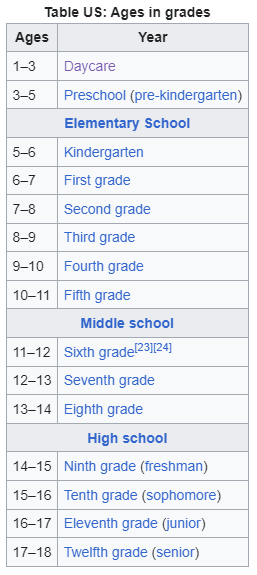

Осталось только разобрать, наш признак.

Учитывая, что в США есть 15 уровней образования, видится разумным сделать признак от 0 до 1 показывающий коэффициент покрытия детским образованием.  
За каждый уровень будем давать 1/15 долю. Это будет коэффициент для школы. А потом из них посчитать среднее.

In [122]:
# сделаем функцию для разбора
def grades_analysis(grades):
    
    def list_grades_to_int(list_grades):
        # заменим текстовые обозначения цифровыми: Preschool (pre-kindergarten) - -1; Kindergarten - 0.
        # и переведем все в числовой формат
        ln_list_grades = len(list_grades)
        for ls in range(ln_list_grades):
            ln_ls = len(list_grades[ls])
            for gr in range(ln_ls):
                if list_grades[ls][gr] == 'K':
                    list_grades[ls][gr] = 0
                elif list_grades[ls][gr] == 'PK':
                    list_grades[ls][gr] = -1
                else:
                    try:
                        list_grades[ls][gr] = int(list_grades[ls][gr])
                    except ValueError:
                        list_grades[ls][gr] = -2
        return list_grades

    def unpack_list_grades(list_grades):
        # раскроем диапазоны
        ln_list_grades = len(list_grades)
        for ls in range(ln_list_grades):
            ln_ls = len(list_grades[ls])
            if ln_ls == 2:
                diff_ls = list_grades[ls][1] - list_grades[ls][0] + 1
                ls_grades_new = []
                for i in range(diff_ls):
                    ls_grades_new.append(list_grades[ls][0] + i)
                list_grades[ls] = ls_grades_new
        return list_grades

    def flatten(lst):
        # Функция для выпрямления списка
        # Создаём новый пустой список
        result = []
        # Создаём цикл по элементам списка
        for elem in lst:
            # Если элемент списка является списком,
            if type(elem) is list:
                # Применяем к нему функцию выпрямления и добавляем элементы к результату
                result += flatten(elem)
            else: # Если элемент не является списоком,
                # Добавляем элемент в новый список
                result.append(elem)
        return result

    # удаляем лишние пробелы, переводим в верхний регистр
    if grades == None: grades=''
    grades = ' '.join(grades.strip().split()).upper()
    # Немного преобразований для стандартизации
    grades = grades.replace('PRESCHOOL', 'PK').replace('TO', '-').replace('–', '-').replace(' ', '')
    grades = grades.split(',')
    grades = list(map(lambda x: x.split('-'), grades))
    # преводим в цифровой формат
    grades = list_grades_to_int(grades)
    # раскрываем диапазоны
    grades = unpack_list_grades(grades)
    flatten_grades = flatten(grades)
    if -2 in flatten_grades:
        flatten_grades.remove(-2)
    result = len(flatten_grades) * (1/15)
    
    return grades, flatten_grades, result

# Выведем в столбик все уникальные значения которые встречаются.
# И попробуем их разобрать
ls = list(school_grades)
for i in ls:
    print(i, grades_analysis(i), sep='\t')
    #print(i)


3-8	([[3, 4, 5, 6, 7, 8]], [3, 4, 5, 6, 7, 8], 0.4)
3	([[3]], [3], 0.06666666666666667)
6–10	([[6, 7, 8, 9, 10]], [6, 7, 8, 9, 10], 0.3333333333333333)
6 to 10	([[6, 7, 8, 9, 10]], [6, 7, 8, 9, 10], 0.3333333333333333)
5–11	([[5, 6, 7, 8, 9, 10, 11]], [5, 6, 7, 8, 9, 10, 11], 0.4666666666666667)
K-2	([[0, 1, 2]], [0, 1, 2], 0.2)
2-4	([[2, 3, 4]], [2, 3, 4], 0.2)
PK-7	([[-1, 0, 1, 2, 3, 4, 5, 6, 7]], [-1, 0, 1, 2, 3, 4, 5, 6, 7], 0.6)
PK-1	([[-1, 0, 1]], [-1, 0, 1], 0.2)
PK-4	([[-1, 0, 1, 2, 3, 4]], [-1, 0, 1, 2, 3, 4], 0.4)
2–5	([[2, 3, 4, 5]], [2, 3, 4, 5], 0.26666666666666666)
K to 6	([[0, 1, 2, 3, 4, 5, 6]], [0, 1, 2, 3, 4, 5, 6], 0.4666666666666667)
1 to 11	([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 0.7333333333333333)
PK–PK	([[-1]], [-1], 0.06666666666666667)
PK, 3-5	([[-1], [3, 4, 5]], [-1, 3, 4, 5], 0.26666666666666666)
PK-8	([[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8]], [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8], 0.6666666666666666)
PK–9	([[-1, 0, 1, 2, 3, 4, 5, 6, 

Умеем считать коэффициент покрытия образованием для школы. Осталось соединить все вместе.

In [123]:
# разберем признак
def schools_analysis_2(feature):
    try:
        # получим словарь
        school_data = ast.literal_eval(feature)
        
        # функция для перевода в int значений рейтинга школ
        def rating_to_int(rating):
            try:
                return int(rating.split('/')[0])
            except ValueError:
                return 1
        # функция для перевода во float значений расстояния
        def distance_to_float(distance):
            non_decimal = re.compile(r'[^\d.]+')
            return float(non_decimal.sub('', distance))

        for data in school_data:
            # разбираем rating
            ls_rating = list(map(rating_to_int, data['rating'])) # получили список
            if len(ls_rating) > 0:
                av_rating = round(sum(ls_rating) / len(ls_rating), 3) # посчитали среднее
            else:
                av_rating = np.nan
            
            # разбираем distance
            ls_distance = list(map(distance_to_float, data['data']['Distance'])) # получили список
            if len(ls_distance) > 0:
                av_distance = round(sum(ls_distance) / len(ls_distance), 3) # посчитали среднее
            else:
                av_distance = np.nan
            
            # разбираем grades
            ls_shool_grades = []
            for shool_grades in  data['data']['Grades']:
                _, _, grades = grades_analysis(shool_grades)
                ls_shool_grades.append(grades) # получили список
            if len(ls_shool_grades) > 0:
                av_grades = round(sum(ls_shool_grades) / len(ls_shool_grades), 3) # посчитали среднее
            else:
                av_grades = np.nan
            
            
        return pd.Series([av_rating, av_distance, av_grades])
    
    except (KeyError, SyntaxError, ValueError):
        print('Ошибка обработки:', feature)
        return pd.Series([np.nan, np.nan, np.nan])
 
df[['schools_av_rating', 'schools_av_distance', 'schools_av_grades']] = df['schools'].apply(schools_analysis_2)


In [124]:
# Посмотрим на наличие пропусков в данных
cols_null_percent = df[['schools_av_rating', 'schools_av_distance', 'schools_av_grades']].isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_with_null)

schools_av_distance    1.128941
schools_av_grades      1.128941
schools_av_rating      1.107584
dtype: float64

Пропусков немного.

Посмотрим на статистические показатели.

In [125]:
df[['schools_av_rating', 'schools_av_distance', 'schools_av_grades']].describe()

,schools_av_rating,schools_av_distance,schools_av_grades
count,370450.000000,370370.000000,370370.000000
mean,4.826053,2.861808,0.356302
std,1.901266,5.899717,0.092147
min,1.000000,0.000000,0.000000
25%,3.333000,1.062000,0.311000
50%,4.667000,1.778000,0.311000
75%,6.167000,3.288000,0.410000
max,10.000000,1590.830000,0.933000


Настораживает объект с расстоянием до школы в 1590.83 мили. Посмотрим на объекты с расстояниме более 1000 миль.

In [126]:
df[df['schools_av_distance'] > 1000]

,status,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,...,Remodeled year,Heating,Cooling,Parking,lotsize,age_of_the_object,age_of_the_remodeled,schools_av_rating,schools_av_distance,schools_av_grades
110102,FOR SALE,SINGLE FAMILY,2.0,"{'atAGlanceFacts': [{'factValue': '1963', 'fac...",1,SANTA ANA,"[{'rating': ['3/10', '1/10', '4/10'], 'data': ...",890.0,92703,2.0,...,1963.0,AIR,1,0,1481.0,61.0,61.0,2.667,1590.807,0.311
204047,FOR SALE,SINGLE FAMILY,6.0,"{'atAGlanceFacts': [{'factValue': '1949', 'fac...",0,MIAMI BEACH,"[{'rating': ['4/10', '7/10'], 'data': {'Distan...",4173.0,33140,4.0,...,2018.0,AIR,0,1,9589.0,75.0,6.0,5.500,1187.510,0.467
356815,FOR SALE,SINGLE FAMILY,3.0,"{'atAGlanceFacts': [{'factValue': '1963', 'fac...",1,SANTA ANA,"[{'rating': ['3/10', '1/10', '4/10'], 'data': ...",890.0,92703,2.0,...,1963.0,AIR,1,0,1481.0,61.0,61.0,2.667,1590.830,0.311


Возможно это какие-то одиноко стоящие в отдалении от всех населенных пунктов объекты. Пока оставим.

Заполним пропуски медианой.

In [127]:
median_schools_av_rating = df['schools_av_rating'].median()
median_schools_av_distance = df['schools_av_distance'].median()
median_schools_av_grades = df['schools_av_grades'].median()

df['schools_av_rating'] = df['schools_av_rating'].fillna(median_schools_av_rating)
df['schools_av_distance'] = df['schools_av_distance'].fillna(median_schools_av_distance)
df['schools_av_grades'] = df['schools_av_grades'].fillna(median_schools_av_grades)

Удалим первоначальные признаки, которые еще остались в датасете, но теперь нам не нужны.

In [128]:
df = df.drop(columns=['propertyType', 'city', 'stories', 'homeFacts', 'Year built', 'Remodeled year', 'schools'])

Вспомним, что при анализе данных мы выявили, что в данных присутствуют дубли объектов, у которых были вариации в написании одного и того же признака. Соответственно при первом удалении дубликатов, такие дубли не были удалены. Сейчас самое время повторить процедуру.

In [129]:
# Проверим наличие полных дубликатов
number_of_duplicates = df[df.duplicated()].shape[0]
print(f'Количество дубликатов: {number_of_duplicates}')

Количество дубликатов: 2810


In [130]:
# Удаляем дубликаты:
df = df.drop_duplicates()
print(f'Размер таблицы после удаления дубликатов: {df.shape}')

Размер таблицы после удаления дубликатов: (371789, 22)


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 371789 entries, 0 to 377184
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                371789 non-null  object 
 1   baths                 371789 non-null  float64
 2   fireplace             371789 non-null  int64  
 3   sqft                  371789 non-null  float64
 4   zipcode               371789 non-null  object 
 5   beds                  371789 non-null  float64
 6   state                 371789 non-null  object 
 7   MlsId                 371789 non-null  int64  
 8   target                371789 non-null  float64
 9   private_pool          371789 non-null  int64  
 10  property_type         371789 non-null  object 
 11  city_2                371789 non-null  object 
 12  stories_2             371789 non-null  float64
 13  Heating               371789 non-null  object 
 14  Cooling               371789 non-null  int64  
 15  Parki

Пора сохранить наш датасет для дальнейшего использования.

In [132]:
compression_opts = dict(method='zip', archive_name='cleared_data.csv')  
df.to_csv('data/cleared_data.zip', index=False, compression=compression_opts)

Так же сохраним использованный нами датасет с городами.

In [133]:
compression_opts = dict(method='zip', archive_name='cities.csv')  
cities.to_csv('data/cities.zip', index=False, compression=compression_opts)

Еще нам понадобятся медианы, которыми мы заполняли пропущенные значения.

In [134]:
df_median = pd.DataFrame({
    'median_beds': [median_beds],
    'median_sqft': [median_sqft],
    'median_year_built': [median_year_built],
    'median_schools_av_rating': [median_schools_av_rating],
    'median_schools_av_distance': [median_schools_av_distance],
    'median_schools_av_grades': [median_schools_av_grades]
})

df_median.to_csv('data/median.csv', index=False)

Мы выполнили очистку довольно загрязненного датасета и подготовили его для использования. Потом, для использования в проде, мы соберем всю обработку по очистке датасета в один файл py. А пока продолжим в другом файле, где проведем стат. анализ и подготовим baseline.  
Продолжени в файле [2_baseline.ipynb](2_baseline.ipynb).